# Speed-dependent Analysis of Walking on the Linear Treadmill
## Brandon Pratt, Updated 04/20/2023 to be consistent with split-belt analysis

Characterize intralimb kinematics and interlimb coordination of flies with and without pertubed proprioception as a function of walking speed

### Import Python Libraries

In [3]:
import os
import os.path
from os import listdir
from os.path import isfile, join
import math
import time

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sea
import scipy.signal

from scipy import signal
from scipy.stats import norm
from scipy.stats import vonmises
from scipy.signal import hilbert
from scipy.ndimage import gaussian_filter1d
from scipy import interpolate
from scipy import stats

### Organize tracked body and leg positions

Also, align the fly to a common heading

In [4]:
def org_data(DF, Rx, Ry, Rz):
    df=DF
    headers = df.columns.values.tolist() # column headers
    fc = np.median(df[headers[0:3]].values, axis = 0)
    bc = np.median(df[headers[6:9]].values, axis = 0)
    chamber_length = np.sqrt((fc[0] - bc[0])**2 + (fc[1] - bc[1])**2 + (fc[2] - bc[2])**2)
    # determine if there needs to be a correction factor
    true_chamber_length=8.929 # known chamber length
    #     chamber_length=2.255
    correction_val=true_chamber_length/chamber_length # convert the tracked positions to actual positions 
    
    # determine division boundary value between the left and right belts
    df=curr_tracked_data

    # perform reference frame transformations on raw data using Euler angles
    # head
    head_mat = np.matrix(df[headers[18:21]])
    transformed_head_mat = np.transpose(np.asarray(np.matmul(Rz,np.matmul(Ry,np.matmul(Rx, np.transpose(head_mat))))))
    head = transformed_head_mat * correction_val  

    # thorax
    thorax_mat = np.matrix(df[headers[24:27]])
    transformed_thorax_mat = np.transpose(np.asarray(np.matmul(Rz,np.matmul(Ry,np.matmul(Rx, np.transpose(thorax_mat))))))
    thorax = transformed_thorax_mat * correction_val

    # abdomen
    abdomen_mat = np.matrix(df[headers[30:33]])
    transformed_abdomen_mat = np.transpose(np.asarray(np.matmul(Rz,np.matmul(Ry,np.matmul(Rx, np.transpose(abdomen_mat))))))
    abdomen = transformed_abdomen_mat * correction_val

    # R1 
    r1_mat = np.matrix(df[headers[36:39]])
    transformed_r1_mat = np.transpose(np.asarray(np.matmul(Rz,np.matmul(Ry,np.matmul(Rx, np.transpose(r1_mat))))))
    r1_raw = transformed_r1_mat * correction_val
    r1 = r1_raw - thorax # normalize these to the thorax (~center of mass)

    # R2
    r2_mat = np.matrix(df[headers[42:45]])
    transformed_r2_mat = np.transpose(np.asarray(np.matmul(Rz,np.matmul(Ry,np.matmul(Rx, np.transpose(r2_mat))))))
    r2_raw = transformed_r2_mat * correction_val
    r2 = r2_raw - thorax

    # R3
    r3_mat = np.matrix(df[headers[48:51]])
    transformed_r3_mat = np.transpose(np.asarray(np.matmul(Rz,np.matmul(Ry,np.matmul(Rx, np.transpose(r3_mat))))))
    r3_raw = transformed_r3_mat * correction_val
    r3 = r3_raw - thorax

    # L1
    l1_mat = np.matrix(df[headers[54:57]])
    transformed_l1_mat = np.transpose(np.asarray(np.matmul(Rz,np.matmul(Ry,np.matmul(Rx, np.transpose(l1_mat))))))
    l1_raw = transformed_l1_mat * correction_val
    l1 = l1_raw - thorax # normalize these to the thorax (~center of mass)

    # L2
    l2_mat = np.matrix(df[headers[60:63]])
    transformed_l2_mat = np.transpose(np.asarray(np.matmul(Rz,np.matmul(Ry,np.matmul(Rx, np.transpose(l2_mat))))))
    l2_raw = transformed_l2_mat * correction_val
    l2 = l2_raw - thorax

    # L3
    l3_mat = np.matrix(df[headers[66:69]])
    transformed_l3_mat = np.transpose(np.asarray(np.matmul(Rz,np.matmul(Ry,np.matmul(Rx, np.transpose(l3_mat))))))
    l3_raw = transformed_l3_mat * correction_val
    l3 = l3_raw - thorax
    
    # collect y positions of tarsi in chamber coordinates
    tarsi_pos_chamber = [r1_raw, r2_raw, r3_raw, l1_raw, l2_raw, l3_raw]

    # seperate legs into there own dimensions
    # isolate the x position only of the legs
    r1_x=r1[:,0]
    r2_x=r2[:,0]
    r3_x=r3[:,0]
    l1_x=l1[:,0]
    l2_x=l2[:,0]
    l3_x=l3[:,0]

    x_pos_raw=[r1_x, r2_x, r3_x, l1_x, l2_x, l3_x]

    # isolate the y position only of the legs
    r1_y=r1[:,1]
    r2_y=r2[:,1]
    r3_y=r3[:,1]
    l1_y=l1[:,1]
    l2_y=l2[:,1]
    l3_y=l3[:,1]

    y_pos_raw=[r1_y, r2_y, r3_y, l1_y, l2_y, l3_y]

    # isolate the x position only of the legs
    r1_z=r1[:,2]
    r2_z=r2[:,2]
    r3_z=r3[:,2]
    l1_z=l1[:,2]
    l2_z=l2[:,2]
    l3_z=l3[:,2]

    z_pos=[r1_z, r2_z, r3_z, l1_z, l2_z, l3_z]
    
    # only look are raw position
    r1_x_raw =r1_raw[:,0]
    r2_x_raw =r2_raw[:,0]
    r3_x_raw =r3_raw[:,0]
    l1_x_raw =l1_raw[:,0]
    l2_x_raw =l2_raw[:,0]
    l3_x_raw =l3_raw[:,0]
    x_pos_allocentric = [r1_x_raw, r2_x_raw, r3_x_raw, l1_x_raw, l2_x_raw, l3_x_raw]
    
    # only look are raw position
    r1_y_raw =r1_raw[:,1]
    r2_y_raw =r2_raw[:,1]
    r3_y_raw =r3_raw[:,1]
    l1_y_raw =l1_raw[:,1]
    l2_y_raw =l2_raw[:,1]
    l3_y_raw =l3_raw[:,1]
    y_pos_allocentric = [r1_y_raw, r2_y_raw, r3_y_raw, l1_y_raw, l2_y_raw, l3_y_raw]
    
    # only look are raw position
    r1_z_raw =r1_raw[:,2]
    r2_z_raw =r2_raw[:,2]
    r3_z_raw =r3_raw[:,2]
    l1_z_raw =l1_raw[:,2]
    l2_z_raw =l2_raw[:,2]
    l3_z_raw =l3_raw[:,2]
    z_pos_raw = [r1_z_raw, r2_z_raw, r3_z_raw, l1_z_raw, l2_z_raw, l3_z_raw]
    
    # convert head, thorax, and abdomen arrays into dataframes
    head = pd.DataFrame(head, columns=headers[18:21])
    thorax = pd.DataFrame(thorax, columns=headers[24:27]) 
    abdomen = pd.DataFrame(abdomen, columns=headers[30:33])

    # transform the data so that the fly is superimposed on itself
#     x_pos = x_pos_raw
#     y_pos = y_pos_raw
    
    [x_pos, y_pos]=coordinate_transform(x_pos_raw, y_pos_raw, thorax, head, abdomen)

    return head, thorax, abdomen, x_pos, y_pos, z_pos, z_pos_raw, tarsi_pos_chamber, x_pos_allocentric, y_pos_allocentric, correction_val

### Align fly to a common heading angle

In [5]:
def coordinate_transform(x_pos, y_pos, thorax, head, abdomen):

    # extract data and adjust for the mirroring in y
    r1_x = x_pos[0]
    r1_y = -y_pos[0] 

    r2_x = x_pos[1]
    r2_y = -y_pos[1] 

    r3_x = x_pos[2]
    r3_y = -y_pos[2] 

    l1_x = x_pos[3]
    l1_y = -y_pos[3] 

    l2_x = x_pos[4]
    l2_y = -y_pos[4] 

    l3_x = x_pos[5]
    l3_y = -y_pos[5] 

    # body position
    tx=thorax['thorax_x'] 
    ty=thorax['thorax_y'] 

    hx=np.array(head['head_x'] - tx.values.astype(float))
    hy=-(np.array(head['head_y'] - ty.values.astype(float)))

    ax=abdomen['abdomen_x'] - tx.values.astype(float)
    ay=-(abdomen['abdomen_y'] - ty.values.astype(float))

    # store variables
    n_frames=len(hx)
    new_hx=np.zeros(n_frames)
    new_hy=np.zeros(n_frames)
    new_ax=np.zeros(n_frames)
    new_ay=np.zeros(n_frames)
    new_r1_x=np.zeros(n_frames)
    new_r1_y=np.zeros(n_frames)
    new_r2_x=np.zeros(n_frames)
    new_r2_y=np.zeros(n_frames)
    new_r3_x=np.zeros(n_frames)
    new_r3_y=np.zeros(n_frames)
    new_l1_x=np.zeros(n_frames)
    new_l1_y=np.zeros(n_frames)
    new_l2_x=np.zeros(n_frames)
    new_l2_y=np.zeros(n_frames)
    new_l3_x=np.zeros(n_frames)
    new_l3_y=np.zeros(n_frames)


    for j in range(n_frames):

        # compute heading angle
        if hx[j]<0:
            sign=-1
            mirror_x=-1 # mirror across x
            mirror_y=-1 # mirror across y

        else:
            sign=1
            mirror_x=1
            mirror_y=1
        l_head=sign*math.sqrt(hx[j]**2 + hy[j]**2) # distance the head is away from the thorax
        heading_angle=math.asin(hy[j]/l_head) # headin angle in radians
        # new head positions
        new_hx[j]=mirror_x*l_head
        new_hy[j]=0 # heading angle should become zero

        # new abdomen position
        if ax[j]<0:
            sign=-1
        else:
            sign=1
        l_abdo=sign*math.sqrt(ax[j]**2 + ay[j]**2)
        abdo_angle=math.asin(ay[j]/l_abdo)
        new_abdo_angle=abdo_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_ax[j]=mirror_x*l_abdo*math.cos(new_abdo_angle)
        new_ay[j]=mirror_y*l_abdo*math.sin(new_abdo_angle)

        # compute the new 2D position of each leg
        # r1
        if r1_x[j]<0:
            sign=-1
        else:
            sign=1
        l_r1=sign*math.sqrt(r1_x[j]**2 + r1_y[j]**2)
        r1_angle=math.asin(r1_y[j]/l_r1)
        new_r1_angle=r1_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_r1_x[j]=mirror_x*l_r1*math.cos(new_r1_angle)
        new_r1_y[j]=mirror_y*l_r1*math.sin(new_r1_angle)

        # r2
        if r2_x[j]<0:
            sign=-1
        else:
            sign=1
        l_r2=sign*math.sqrt(r2_x[j]**2 + r2_y[j]**2)
        r2_angle=math.asin(r2_y[j]/l_r2)
        new_r2_angle=r2_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_r2_x[j]=mirror_x*l_r2*math.cos(new_r2_angle)
        new_r2_y[j]=mirror_y*l_r2*math.sin(new_r2_angle)

        # r3
        if r3_x[j]<0:
            sign=-1
        else:
            sign=1
        l_r3=sign*math.sqrt(r3_x[j]**2 + r3_y[j]**2)
        r3_angle=math.asin(r3_y[j]/l_r3)
        new_r3_angle=r3_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_r3_x[j]=mirror_x*l_r3*math.cos(new_r3_angle)
        new_r3_y[j]=mirror_y*l_r3*math.sin(new_r3_angle)

        # l1
        if l1_x[j]<0:
            sign=-1
        else:
            sign=1
        l_l1=sign*math.sqrt(l1_x[j]**2 + l1_y[j]**2)
        l1_angle=math.asin(l1_y[j]/l_l1)
        new_l1_angle=l1_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_l1_x[j]=mirror_x*l_l1*math.cos(new_l1_angle)
        new_l1_y[j]=mirror_y*l_l1*math.sin(new_l1_angle)

        # l2
        if l2_x[j]<0:
            sign=-1
        else:
            sign=1
        l_l2=sign*math.sqrt(l2_x[j]**2 + l2_y[j]**2)
        l2_angle=math.asin(l2_y[j]/l_l2)
        new_l2_angle=l2_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_l2_x[j]=mirror_x*l_l2*math.cos(new_l2_angle)
        new_l2_y[j]=mirror_y*l_l2*math.sin(new_l2_angle)

        # l3
        if l3_x[j]<0:
            sign=-1
        else:
            sign=1
        l_l3=sign*math.sqrt(l3_x[j]**2 + l3_y[j]**2)
        l3_angle=math.asin(l3_y[j]/l_l3)
        new_l3_angle=l3_angle - heading_angle # compute angle of r1 adjusted by the heading angle
        new_l3_x[j]=mirror_x*l_l3*math.cos(new_l3_angle)
        new_l3_y[j]=mirror_y*l_l3*math.sin(new_l3_angle)

    # store leg arrays
    x_pos=[new_r1_x, new_r2_x, new_r3_x, new_l1_x, new_l2_x, new_l3_x]
    y_pos=[-new_r1_y, -new_r2_y, -new_r3_y, -new_l1_y, -new_l2_y, -new_l3_y]

    # store rotated body arrays
    rot_head=[new_hx, new_hy]
    rot_abdomen=[new_ax, new_ay]

    return x_pos, y_pos
   

### Calculate the velocity of the fly

Ground truth velocity of the belts in the tied condition is between 7-7.5 mm/s. This was confirmed using the movement of the belt teeth as seen by the top down camera in Fiji. 

Compute the flies walking speed w.r.t to the driving speed direction

In [6]:
def compute_vel(head, thorax, trial_speed):
    
    # velocity parameters 
    dt = 1/FS
    tx=thorax['thorax_x'] 
    ty=thorax['thorax_y'] 
    tz=thorax['thorax_z']
    dx=np.diff(tx)
    dy=np.diff(ty)
    dz=np.diff(tz)
    
    # calculate total velocity
    M = np.sqrt(dx**2 + dy**2 + dz**2)
    sign=np.ones(len(dx))
    sign[np.where(dx<0)[0]]=-1
    vel = (sign*M)/dt + trial_speed
    
    # filter the velocity with a 1D Gaussian filter with sigma of 2
    sigma = 2
    filt_vel = gaussian_filter1d(vel, sigma)
    lin_vel = filt_vel
    
    # calculate the fly's walking speed parallel to the driving speed axis
    vel_parallel = vel = dx/dt + trial_speed
    filt_vel_parallel = gaussian_filter1d(vel_parallel, sigma)
    
    # calculate the fly's walking speed perpendicular to the driving speed axis
    vel_perpendicular = abs(dy)/dt 
    filt_vel_perpendicular = gaussian_filter1d(vel_perpendicular, sigma)
              
    # compute heading angle
    # body position
    hx=np.array(head['head_x'] - tx.values.astype(float))
    hy=-(np.array(head['head_y'] - ty.values.astype(float)))
   
    heading_angle=np.zeros(len(hx))
    for j in range(len(hx)):
        # compute heading angle
        if hx[j]<0:
            
            # adjust for 180 degrees
            sign=-1
            l_head=sign*math.sqrt(hx[j]**2 + hy[j]**2) # distance the head is away from the thorax
            angle=math.asin(hy[j]/l_head) # headin angle in radians
            if angle<0:
                heading_angle[j]=math.degrees((math.pi + angle))
            else:
                heading_angle[j]=math.degrees((angle - math.pi))
            
        else:
            sign=1
            l_head=sign*math.sqrt(hx[j]**2 + hy[j]**2) # distance the head is away from the thorax
            heading_angle[j]=math.degrees(math.asin(hy[j]/l_head)) # headin angle in radians
            
    return lin_vel, filt_vel_parallel, filt_vel_perpendicular, heading_angle
    

### Estimate Body Length

Normalize spatial kinematic parameters by body length so that comparasions between flies can be conducted.

Normalize by dividing spatial parameter by body length [mm]

In [7]:
def estimate_BL(head, abdomen):

    # head coordinates
    hx = head['head_x']
    hy = head['head_y']
    hz = head['head_z']

    # abdomen coordinates
    ax = abdomen['abdomen_x']
    ay = abdomen['abdomen_y']
    az = abdomen['abdomen_z']

    # compute the difference
    dx = hx - ax
    dy = hy - ay
    dz = hz - az

    # Calculate the body lengths for the trial
    BL = np.sqrt(dx**2 + dy**2 + dz**2)

    # filter the body length for when the fly is walking
    #filtered_BL = BL[walking_indices]

    # calculate the median BL
    median_BL = np.median(BL)
    
    return median_BL

### Compute step amplitude or stride length 
stride length: AEP to subsequent AEP (PROBLEM: walking in place results in no change in this parameter)

step amplitude: total distance between PEP and AEP (focus on this)

swing distance 


In [8]:
def compute_swing_distance(stance_start, stance_end, x_pos, y_pos, z_pos_raw, BL):
    swing_distance =  np.empty((nlegs, trial_samples))
    swing_distance[:] = np.nan
    for leg in range(len(stance_start)):
        for j in range(len(stance_start[leg])-1):
            # compute step length
            dx = x_pos[leg][stance_end[leg][j]:stance_start[leg][j+1]] 
            dy = y_pos[leg][stance_end[leg][j]:stance_start[leg][j+1]]
            dz = z_pos_raw[leg][stance_end[leg][j]:stance_start[leg][j+1]] 
#             amplitude=np.sum(np.sqrt(np.diff(dx)**2 + np.diff(dy)**2 + np.diff(dz)**2))/BL # 3D
            amplitude=np.sum(np.sqrt(np.diff(dx)**2 + np.diff(dy)**2))/BL

            # filter out zero distance because it is attibuted to a tracking error
            if amplitude > 0:
                swing_distance[leg,stance_start[leg][j]] = amplitude # normalize by body length

    return swing_distance

In [9]:
def compute_stance_distance(stance_start, stance_end, x_pos, y_pos, z_pos_raw, BL):
    stance_distance =  np.empty((nlegs, trial_samples))
    stance_distance[:] = np.nan
    for leg in range(len(stance_start)):
        for j in range(len(stance_start[leg])):
            # compute step length
            dx = x_pos[leg][stance_start[leg][j]:stance_end[leg][j]]
            dy = y_pos[leg][stance_start[leg][j]:stance_end[leg][j]]
            dz = z_pos_raw[leg][stance_start[leg][j]:stance_end[leg][j]] 
            amplitude=np.sum(np.sqrt(np.diff(dx)**2 + np.diff(dy)**2 + np.diff(dz)**2))/BL

            # filter out zero distance because it is attibuted to a tracking error
            if amplitude > 0:
                stance_distance[leg,stance_start[leg][j]] = amplitude # normalize by body length
            
    return stance_distance

In [10]:
def compute_step_distance(x_pos, y_pos, z_pos_raw, stance_start, stance_end, BL, FS):
    step_distance =  np.empty((nlegs, trial_samples))
    step_distance[:] = np.nan
    
    # compute stance and swing speed and sum both from step speed
    for leg in range(len(stance_start)):
        # calculate the stance and swing speed for each step
        for j in range(len(stance_start[leg])-1):

            # compute distance traveled during the step
            # stance distance
            st_dx = x_pos[leg][stance_start[leg][j]:stance_end[leg][j]] 
            st_dy = y_pos[leg][stance_start[leg][j]:stance_end[leg][j]]
            st_dz = z_pos_raw[leg][stance_start[leg][j]:stance_end[leg][j]]
            st_distance = np.sum(np.sqrt(np.diff(st_dx)**2 + np.diff(st_dy)**2))/BL

            # swing distance
            sw_dx = x_pos[leg][stance_end[leg][j]:stance_start[leg][j+1]] 
            sw_dy = y_pos[leg][stance_end[leg][j]:stance_start[leg][j+1]]
            sw_dz = z_pos_raw[leg][stance_end[leg][j]:stance_start[leg][j+1]] 
            sw_distance = np.sum(np.sqrt(np.diff(sw_dx)**2 + np.diff(sw_dy)**2))/BL

            # step distance
            step_dist = st_distance + sw_distance
            
            if (st_distance > 0) and (sw_distance > 0):
                step_distance[leg, stance_start[leg][j]] = step_dist
                
    return step_distance 
                                 

In [11]:
def compute_step_length(x_pos_allocentric, y_pos_allocentric, stance_start, stance_end, FS, BL):
    '''Step Length = the distance during stance + distance during swing + correction for the treadmill moving the body backwards'''
    # NOTE: Step Length should be in the allocentric (camera frame) reference frame

    step_length =  np.empty((nlegs, trial_samples))
    step_length[:] = np.nan

    # compute stance and swing distance + correction for treadmill
    for leg in range(len(stance_start)):
        # calculate the stance and swing distance for each step
        for j in range(len(stance_start[leg])-1):

            # compute distance traveled during the step
            # stance distance
            st_dx = x_pos_allocentric[leg][stance_start[leg][j]:stance_end[leg][j]] 
            st_dy = y_pos_allocentric[leg][stance_start[leg][j]:stance_end[leg][j]]
            st_distance = np.sum(np.sqrt(np.diff(st_dx)**2 + np.diff(st_dy)**2))/BL

            # swing distance
            sw_dx = x_pos_allocentric[leg][stance_end[leg][j]:stance_start[leg][j+1]] 
            sw_dy = y_pos_allocentric[leg][stance_end[leg][j]:stance_start[leg][j+1]]
            sw_distance = np.sum(np.sqrt(np.diff(sw_dx)**2 + np.diff(sw_dy)**2))/BL

            # correction for the treadmill moving backwards
            '''Correction derived by the average stance distance * timesteps during swing
            OR the driving speed * swing duration 
            '''
    #         dist_treadmill = (np.nanmean(np.sqrt(np.diff(st_dx)**2 + np.diff(st_dy)**2)) * len(sw_dx))/BL

            # alternative approach - use the driving speed to determine a fix displacement
            sw_duration = len(sw_dx) * (1/FS)
            dist_treadmill = (sw_duration * trial_speed)/BL 

            # step length
            step_l = st_distance + sw_distance + dist_treadmill

            if (st_distance > 0) and (sw_distance > 0):
                step_length[leg, stance_start[leg][j]] = step_l
    return step_length

### Swing and Stance Duration, and Duty Factor

In [12]:
def swing_stance_duration(stance_start, stance_end):
    stance_duration =  np.empty((nlegs, trial_samples))
    stance_duration[:] = np.nan

    swing_duration =  np.empty((nlegs, trial_samples))
    swing_duration[:] = np.nan

    duty_factor =  np.empty((nlegs, trial_samples))
    duty_factor[:] = np.nan

    for leg in range(len(stance_start)):
        for j in range(len(stance_start[leg])-1):
            stance_delt=(stance_end[leg][j]-stance_start[leg][j])/FS
            if stance_delt > 0:
                stance_duration[leg, stance_start[leg][j]] = stance_delt

            swing_delt=(stance_start[leg][j+1] - stance_end[leg][j])/FS
            if swing_delt > 0:
                swing_duration[leg, stance_start[leg][j]] = swing_delt

            # compute the duty factor
            if (swing_delt > 0) and (stance_delt > 0):
                df=stance_delt/(stance_delt + swing_delt)
                duty_factor[leg, stance_start[leg][j]] = df
    
    return stance_duration, swing_duration, duty_factor

### Step Frequency
step frequency: 1/ change in time between stance starts

In [13]:
def compute_step_freq(stance_start):
    step_frequency =  np.empty((nlegs, trial_samples))
    step_frequency[:] = np.nan
    for leg in range(len(stance_start)):
        for j in range(len(stance_start[leg])-1):
            step_duration=(stance_start[leg][j+1] - stance_start[leg][j])/FS
            if step_duration>0:
                step_frequency[leg, stance_start[leg][j]] = 1/step_duration
    
    return step_frequency

### Swing Height

Calculate the height of swing for each leg

In [14]:
# compute swing height
def compute_swing_height(x_pos, y_pos, z_pos_raw, stance_start, stance_end, BL):
    swing_height =  np.empty((nlegs, trial_samples))
    swing_height[:] = np.nan
    buffer_frames = 3
    for leg in range(len(stance_start)):
        for j in range(len(stance_start[leg])-1):

            # determine the max height of the step
            curr_swing = z_pos_raw[leg][stance_end[leg][j] - buffer_frames : stance_start[leg][j+1] + buffer_frames] /BL
            max_z = max(curr_swing)

            # determine the median z value during the preceeding stance
            mean_stance_z = np.mean(z_pos_raw[leg][stance_start[leg][j]:stance_end[leg][j]] /BL)

            # height of swing
            curr_h = abs(max_z- mean_stance_z)
            if curr_h > 0:
                swing_height[leg, stance_start[leg][j]] = curr_h

    return swing_height

### Swing Linearity

Measure how how variable the lateral movement of the leg during swing is relative to following the shortest path possible from PEP to AEP

In [15]:
def compute_swing_linearity(x_pos, y_pos, stance_start, stance_end, BL):
    swing_linearity =  np.empty((nlegs, trial_samples))
    swing_linearity[:] = np.nan
    N = 100 # number of samples for interpolation (swing phase)

    for leg in range(len(stance_start)):
        for j in range(len(stance_start[leg])-1):

            # current swing trajectory along x and y (body and lateral axes)
            curr_swing_x = x_pos[leg][stance_end[leg][j]:stance_start[leg][j+1]] /BL
            curr_swing_y = y_pos[leg][stance_end[leg][j]:stance_start[leg][j+1]] /BL

            # interpolate
            if len(curr_swing_x) > 2:
                fx = interpolate.interp1d(curr_swing_x , curr_swing_y)
                interp_x = np.linspace(curr_swing_x[0], curr_swing_x[-1], N)
                ynew = fx(interp_x)
                ynew_adj = ynew - ynew[0]


                # create the straight (shortest path)
                straight_traj = np.linspace(ynew_adj[0], ynew_adj[-1], N)
                error = np.sum(abs(ynew_adj - straight_traj)) # absolute error from path

            else:
                error = np.nan

            # store absolute error 
            swing_linearity[leg, stance_start[leg][j]] = error
            
    return swing_linearity


### Step, stance, and swing speeds

$$speed = \frac{distance}{duration} [BL/s] $$

In [16]:
def compute_tarsi_speeds(x_pos, y_pos, z_pos_raw, stance_start, stance_end, BL, FS):
    step_speed =  np.empty((nlegs, trial_samples))
    step_speed[:] = np.nan
    
    stance_speed =  np.empty((nlegs, trial_samples))
    stance_speed[:] = np.nan
    
    swing_speed =  np.empty((nlegs, trial_samples))
    swing_speed[:] = np.nan

    # compute stance and swing speed and sum both from step speed
    for leg in range(len(stance_start)):
        # calculate the stance and swing speed for each step
        for j in range(len(stance_start[leg])-1):
            # determine stance and swing duration
            st_d = (stance_end[leg][j] - stance_start[leg][j])/FS # stance duration
            sw_d = (stance_start[leg][j+1] - stance_end[leg][j])/FS
            step_d = st_d + sw_d

            # compute distance traveled during the step
            # stance distance
            st_dx = x_pos[leg][stance_start[leg][j]:stance_end[leg][j]] 
            st_dy = y_pos[leg][stance_start[leg][j]:stance_end[leg][j]]
            st_dz = z_pos_raw[leg][stance_start[leg][j]:stance_end[leg][j]]
            st_distance = np.sum(np.sqrt(np.diff(st_dx)**2 + np.diff(st_dy)**2 + np.diff(st_dz)**2))/BL

            # swing distance
            sw_dx = x_pos[leg][stance_end[leg][j]:stance_start[leg][j+1]] 
            sw_dy = y_pos[leg][stance_end[leg][j]:stance_start[leg][j+1]]
            sw_dz = z_pos_raw[leg][stance_end[leg][j]:stance_start[leg][j+1]] 
            sw_distance = np.sum(np.sqrt(np.diff(sw_dx)**2 + np.diff(sw_dy)**2 + np.diff(sw_dz)**2))/BL

            # step distance
            step_distance = st_distance + sw_distance
            
            if (st_d > 0) and (sw_d > 0):
                step_speed[leg, stance_start[leg][j]] = step_distance/step_d
                stance_speed[leg, stance_start[leg][j]] = st_distance/st_d
                swing_speed[leg, stance_start[leg][j]] = sw_distance/sw_d

    return step_speed, stance_speed, swing_speed  


### AEP and PEP
AEP: Anterior extreme position, stance start...use stance time

PEP: Posterior extreme position, stance end...use swing time

In [17]:
# compute the AEP and PEP 
def compute_AEP_PEP(x_pos, y_pos, stance_start, stance_end, BL):
    AEPx =  np.empty((nlegs, trial_samples))
    AEPx[:] = np.nan
    AEPy =  np.empty((nlegs, trial_samples))
    AEPy[:] = np.nan
    PEPx =  np.empty((nlegs, trial_samples))
    PEPx[:] = np.nan
    PEPy =  np.empty((nlegs, trial_samples))
    PEPy[:] = np.nan
    
    for leg in range(len(stance_start)):
        for j in range(len(stance_start[leg])- 1):
            # determine x and y position of AEP at the onset of stance normalized by body length
            AEPx[leg, stance_start[leg][j]] = x_pos[leg][stance_start[leg][j]]/BL
            AEPy[leg, stance_start[leg][j]] = y_pos[leg][stance_start[leg][j]]/BL

            # determine x and y position of PEP at swing start/ end of stance phase normalized by body length
            PEPx[leg, stance_start[leg][j]] = x_pos[leg][stance_end[leg][j]]/BL
            PEPy[leg, stance_start[leg][j]] = y_pos[leg][stance_end[leg][j]]/BL

    return AEPx, AEPy, PEPx, PEPy

### Coordination Parameters

#### Fractional coordination - delay in stance onset between legs using a reference leg

1) L1 - R1 [3,0]

2) L1 - R2 [3,1]

3) L1 - R3 [3,2]

4) L1 - L2 [3,4]

5) L1 - L3 [3,5]

6) L2 - R1 [4,0]

7) L2 - R2 [4,1]

8) L2 - R3 [4,2]

9) L2 - L3 [4,5]

10) L3 - R1 [5,0]

11) L3 - R2 [5,1]

12) L3 - R3 [5,2]

13) R1 - R2 [0,1]

14) R2 - R3 [1,2]

#### Relative distance between legs at the AEP (stance start) of reference leg

Distance = sqrt(X^2 + Y^2 + Z^2)

In [39]:
# Compare the phase relationship between legs
def relative_phase_distance(stance_start, x_pos, y_pos, z_pos_raw, trial_samples):
    leg_comparasions = [[3,0], [3,1], [3,2], [3,4], [3,5], [4,0], [4,1], [4,2], [4,5], [5,0], [5,1], [5,2], [0,1], [1,2]]
    step_phase = -np.ones((len(leg_comparasions), trial_samples))
    relative_distance = -np.ones((len(leg_comparasions), trial_samples))
    for j in range(len(leg_comparasions)):
        leg1 = leg_comparasions[j][0]
        leg2 = leg_comparasions[j][1]

        for i in range(len(stance_start[leg1])-1):
            stance_index = stance_start[leg2][np.logical_and(stance_start[leg2] >= stance_start[leg1][i], stance_start[leg2] < stance_start[leg1][i+1])]

            if len(stance_index) > 0: # make sure there is a match - only consider the first index
                step_phase[j, stance_start[leg1][i]] = (stance_index[0]-stance_start[leg1][i])/(stance_start[leg1][i+1]-stance_start[leg1][i])

                # relative distance
                dx = x_pos[leg1] - x_pos[leg2]
                dy = y_pos[leg1] - y_pos[leg2]
                dz = z_pos_raw[leg1] - z_pos_raw[leg2]
                relative_distance[j, stance_start[leg1][i]] = np.sqrt(dx[stance_start[leg1][i]]**2 + dy[stance_start[leg1][i]]**2 + dz[stance_start[leg1][i]]**2)      
    
    return step_phase, relative_distance

#### Instanteous phase difference between legs

Note that the Hilbert transform works poorly on limb tip positions because the osccilatory nature of them is non-stationary (i.e. there is no one axis that captures the full osccilatory charactistics of leg movement)

#### Stance starts of legs relative to L1

This is also a interlimb phase metric that compliments the method of using a hilbert transform

In [19]:
def compute_relative_stance_onset(stance_start, FS, walking_indices, trial_speed):
    filt_ref_stance_onset = np.intersect1d(stance_start[3], walking_indices) # reference leg is L1, filtered stance onset
    stance_onset_threshold = 0.2 # 200 ms... slowest step duration
    leg_relative_stance_onset =  np.empty((5, trial_samples))
    leg_relative_stance_onset[:] = np.nan
    leg_cnt = -1
    for leg in [0, 1, 2, 4, 5]:
        leg_cnt += 1
        for stance_frame in filt_ref_stance_onset:
            curr_stance_onset = np.intersect1d(stance_start[leg], walking_indices)
            if len(curr_stance_onset) > 0:
                df_stance_onset = curr_stance_onset - stance_frame
                min_idx = np.argmin(np.abs(df_stance_onset))
                dt = (df_stance_onset[min_idx])/FS
                if dt < stance_onset_threshold:
                    leg_relative_stance_onset[leg_cnt, stance_frame] = dt
        
    return leg_relative_stance_onset

### Duration of the number of legs in stance during walking bouts

In [20]:
def legs_in_stance_duration(nlegs_stance, trial_samples):
    # duration of the number of legs in stance
    duration_nlegs = np.zeros((6, trial_samples))
    for j in np.arange(1,7).tolist():
        nleg_idxs = np.where(nlegs_stance == j)[0]
        if len(nleg_idxs>0):
            # iterate through each
            frame_start = nleg_idxs[0]
            frame_counter = 0
            for i in range(len(nleg_idxs)-1):
                frame_counter += 1
                if ((nleg_idxs[i+1] - nleg_idxs[i]) != 1) and (frame_counter > 1):
                    frame_end = nleg_idxs[i]
                    duration_nlegs[j-1, frame_start] = ((frame_end - frame_start)+1)/FS
                    frame_start = nleg_idxs[i+1]
                    frame_counter=0
                elif ((nleg_idxs[i+1] - nleg_idxs[i]) != 1) and (frame_counter == 1): # configuration is just present for 1 frame
                    duration_nlegs[j-1, frame_start] = 1/FS
                    frame_start = nleg_idxs[i+1]
                    frame_counter=0
                elif (i == len(nleg_idxs)-2) and (frame_counter > 1): # right edge case
                    frame_end = nleg_idxs[i+1]
                    duration_nlegs[j-1, frame_start] = ((frame_end - frame_start)+1)/FS
                elif (i == len(nleg_idxs)-2) and (frame_counter == 1):
                    duration_nlegs[j-1, frame_start] = 1/FS
    return duration_nlegs

#### Tripod Coordination Strength

TCS = t2/t1

t2 = time that legs overlap during swing

t1 =  abs(earliest swing onset - latest swing onset)

In [21]:
def tripod_coordination_strength(walking_indices, FS, stance_start, stance_end):

    # find bounds of walking periods
    walking_idx_diff = np.diff(walking_indices)
    walking_bounds = np.where(walking_idx_diff>1)[0]
    walking_periods = []
    start_idx = walking_indices[0]
    for j in range(len(walking_bounds)):

        # boundary effect
        if (len(walking_bounds) == j+1) and (walking_bounds[j] != len(walking_idx_diff)):
            walking_periods.append([start_idx, walking_indices[walking_bounds[j]]])
            start_idx = walking_indices[walking_bounds[j] + 1] 
            walking_periods.append([start_idx, walking_indices[-1]])
        else: # for iterating through more than 2 walking periods
            walking_periods.append([start_idx, walking_indices[walking_bounds[j]]])
            start_idx = walking_indices[walking_bounds[j] + 1] 

    # find swing phases within these walking periods
    right_tcs = np.zeros(trial_samples)
    left_tcs = np.zeros(trial_samples)
    for walking_bout in range(len(walking_periods)):
        # start and end of walking bouts
        start_bout = walking_periods[walking_bout][0]
        end_bout = walking_periods[walking_bout][1]

        # right tripod
        # r1
        r1_swing_onsets = stance_end[0][np.where(np.logical_and(stance_end[0]>= start_bout, stance_end[0]<= end_bout))[0]]
        try:
            r1_swing_end = stance_start[0][np.where(np.logical_and(stance_end[0]>= start_bout, stance_end[0]<= end_bout))[0] + 1]
        except:
            break

        # l2
        l2_swing_onsets = stance_end[4][np.where(np.logical_and(stance_end[4]>= start_bout, stance_end[4]<= end_bout))[0]]
        try:
            l2_swing_end = stance_start[4][np.where(np.logical_and(stance_end[4]>= start_bout, stance_end[4]<= end_bout))[0] + 1]
        except:
            break

        # r3
        r3_swing_onsets = stance_end[2][np.where(np.logical_and(stance_end[2]>= start_bout, stance_end[2]<= end_bout))[0]]
        try:
            r3_swing_end = stance_start[2][np.where(np.logical_and(stance_end[2]>= start_bout, stance_end[2]<= end_bout))[0] + 1]
        except:
            break

        # if sizes of these arrays are not the same then reformat them
        if (len(r1_swing_onsets) != len(l2_swing_onsets)) or (len(r1_swing_onsets) != len(r3_swing_onsets)):
            # use the array that is the smallest in size
            cat_arrays = [r1_swing_onsets, l2_swing_onsets, r3_swing_onsets]
            cat_arrays_end = [r1_swing_end, l2_swing_end, r3_swing_end]
            min_size_array = np.argmin(np.array([len(r1_swing_onsets), len(l2_swing_onsets), len(r3_swing_onsets)]))
            other_array_idxs = np.setdiff1d(np.arange(0,len(cat_arrays)), np.array([min_size_array]))

            for k in range(len(other_array_idxs)):
                if len(cat_arrays[min_size_array]) != len(cat_arrays[other_array_idxs[k]]):

                    # find matches
                    other_array_matches_onset = np.zeros(len(cat_arrays[min_size_array]))
                    other_array_matches_end = np.zeros(len(cat_arrays[min_size_array]))
                    for onset in range(len(cat_arrays[min_size_array])):
                        match_idx = np.argmin(abs(cat_arrays[other_array_idxs[k]] - cat_arrays[min_size_array][onset]))
                        other_array_matches_onset[onset] = cat_arrays[other_array_idxs[k]][match_idx]
                        other_array_matches_end[onset] = cat_arrays_end[other_array_idxs[k]][match_idx]

                    # replace prior array with new array
                    if other_array_idxs[k] == 0:
                        r1_swing_onsets = other_array_matches_onset
                        r1_swing_end = other_array_matches_end
                    elif other_array_idxs[k] == 1:
                        l2_swing_onsets = other_array_matches_onset
                        l2_swing_end = other_array_matches_end
                    else:
                        r3_swing_onsets = other_array_matches_onset
                        r3_swing_end = other_array_matches_end

        for i in range(len(r1_swing_onsets)):
            # enforce that swing termination doesn't exceed the walking bout bounds
            if (r1_swing_end[i] <= end_bout) and (l2_swing_end[i] <= end_bout) and (r3_swing_end[i] <= end_bout):
                # make sure that for the given swing that there is overlap for the legs within the tripod
                r1_swing_frames= np.arange(r1_swing_onsets[i], r1_swing_end[i]+1)
                l2_swing_frames= np.arange(l2_swing_onsets[i], l2_swing_end[i]+1)
                r3_swing_frames= np.arange(r3_swing_onsets[i], r3_swing_end[i]+1)

                # see if they intersect
                if (len(np.intersect1d(r1_swing_frames, l2_swing_frames))>0) and (len(np.intersect1d(r1_swing_frames, r3_swing_frames))>0) and (len(np.intersect1d(l2_swing_frames, r3_swing_frames))>0):
                    # if all of the legs within a tripod share frames, then compute tcs
                    curr_swing_onset = np.array([r1_swing_onsets[i], l2_swing_onsets[i], r3_swing_onsets[i]])
                    curr_swing_end = np.array([r1_swing_end[i], l2_swing_end[i], r3_swing_end[i]])

                    # compute the total duration of the tripod
                    t1 = (max(curr_swing_end) - min(curr_swing_onset))/FS

                    # compute the time that all legs are in swing together
                    overlap_r1_l2 = np.intersect1d(r1_swing_frames, l2_swing_frames)
                    overlap_all_legs = np.intersect1d(overlap_r1_l2, r3_swing_frames)
                    t2 = (overlap_all_legs[-1] - overlap_all_legs[0])/FS
                    right_tcs[int(overlap_all_legs[0])] = t2/t1


        # left tripod
        # l1
        l1_swing_onsets = stance_end[3][np.where(np.logical_and(stance_end[3]>= start_bout, stance_end[3]<= end_bout))[0]]
        try:
            l1_swing_end = stance_start[3][np.where(np.logical_and(stance_end[3]>= start_bout, stance_end[3]<= end_bout))[0] + 1]
        except:
            break

        # r2
        r2_swing_onsets = stance_end[1][np.where(np.logical_and(stance_end[1]>= start_bout, stance_end[1]<= end_bout))[0]]
        try:
            r2_swing_end = stance_start[1][np.where(np.logical_and(stance_end[1]>= start_bout, stance_end[1]<= end_bout))[0] + 1]
        except:
            break

        # l3
        l3_swing_onsets = stance_end[5][np.where(np.logical_and(stance_end[5]>= start_bout, stance_end[5]<= end_bout))[0]]
        try:
            l3_swing_end = stance_start[5][np.where(np.logical_and(stance_end[5]>= start_bout, stance_end[5]<= end_bout))[0] + 1]
        except:
            break

        # if sizes of these arrays are not the same then reformat them
        if (len(l1_swing_onsets) != len(r2_swing_onsets)) or (len(l1_swing_onsets) != len(l3_swing_onsets)):
            # use the array that is the smallest in size
            cat_arrays = [l1_swing_onsets, r2_swing_onsets, l3_swing_onsets]
            cat_arrays_end = [l1_swing_end, r2_swing_end, l3_swing_end]
            min_size_array = np.argmin(np.array([len(l1_swing_onsets), len(r2_swing_onsets), len(l3_swing_onsets)]))
            other_array_idxs = np.setdiff1d(np.arange(0,len(cat_arrays)), np.array([min_size_array]))

            for k in range(len(other_array_idxs)):
                if len(cat_arrays[min_size_array]) != len(cat_arrays[other_array_idxs[k]]):

                    # find matches
                    other_array_matches_onset = np.zeros(len(cat_arrays[min_size_array]))
                    other_array_matches_end = np.zeros(len(cat_arrays[min_size_array]))
                    for onset in range(len(cat_arrays[min_size_array])):
                        match_idx = np.argmin(abs(cat_arrays[other_array_idxs[k]] - cat_arrays[min_size_array][onset]))
                        other_array_matches_onset[onset] = cat_arrays[other_array_idxs[k]][match_idx]
                        other_array_matches_end[onset] = cat_arrays_end[other_array_idxs[k]][match_idx]

                    # replace prior array with new array
                    if other_array_idxs[k] == 0:
                        l1_swing_onsets = other_array_matches_onset
                        l1_swing_end = other_array_matches_end
                    elif other_array_idxs[k] == 1:
                        r2_swing_onsets = other_array_matches_onset
                        r2_swing_end = other_array_matches_end
                    else:
                        l3_swing_onsets = other_array_matches_onset
                        l3_swing_end = other_array_matches_end

        for i in range(len(r2_swing_onsets)):
            # enforce that swing termination doesn't exceed the walking bout bounds
            if (l1_swing_end[i] <= end_bout) and (r2_swing_end[i] <= end_bout) and (l3_swing_end[i] <= end_bout):
                # make sure that for the given swing that there is overlap for the legs within the tripod
                l1_swing_frames= np.arange(l1_swing_onsets[i], l1_swing_end[i]+1)
                r2_swing_frames= np.arange(r2_swing_onsets[i], r2_swing_end[i]+1)
                l3_swing_frames= np.arange(l3_swing_onsets[i], l3_swing_end[i]+1)

                # see if they intersect
                if (len(np.intersect1d(l1_swing_frames, r2_swing_frames))>0) and (len(np.intersect1d(l1_swing_frames, l3_swing_frames))>0) and (len(np.intersect1d(r2_swing_frames, l3_swing_frames))>0):
                    # if all of the legs within a tripod share frames, then compute tcs
                    curr_swing_onset = np.array([l1_swing_onsets[i], r2_swing_onsets[i], l3_swing_onsets[i]])
                    curr_swing_end = np.array([l1_swing_end[i], r2_swing_end[i], l3_swing_end[i]])

                    # compute the total duration of the tripod
                    t1 = (max(curr_swing_end) - min(curr_swing_onset))/FS

                    # compute the time that all legs are in swing together
                    overlap_l1_r2 = np.intersect1d(l1_swing_frames, r2_swing_frames)
                    overlap_all_legs = np.intersect1d(overlap_l1_r2, l3_swing_frames)
                    t2 = (overlap_all_legs[-1] - overlap_all_legs[0])/FS
                    left_tcs[int(overlap_all_legs[0])] = t2/t1
                    
    return right_tcs, left_tcs
    

### Posture Parameters

#### Calculate body height

body height will be determined as the median stance height, which is normalized to thorax height. Thorax height can't be used because it needs to be relative to the distance the fly is from the belt... i.e. leg in stance to thorax height

In [22]:
def comupte_body_height(swing_stance_mat, z_pos, BL):
    bh = np.zeros(swing_stance_mat.shape[1])
    for j in range(len(bh)):

        # find the legs in stance - middle legs only
        stance_boolean = swing_stance_mat[[1,4], j] == 1

        # legs are in stance
        if np.any(stance_boolean):
            z_pos_midlegs = np.concatenate((np.array([z_pos[1][j]]), np.array([z_pos[4][j]])))
            curr_bh = np.mean(z_pos_midlegs[stance_boolean])

        else:
            curr_bh = np.nan

        # append median height to body height array
        bh[j] = curr_bh/BL

    # linear interpolation over the NANs
    non_nan_frames = all_frames[~np.isnan(bh)]
    non_nan_bh = bh[~np.isnan(bh)]
    f = interpolate.interp1d(non_nan_frames, non_nan_bh, fill_value = 'extrapolate')
    interp_bh = f(all_frames)

    # smooth body height via a Gaussian Kernel
    bh_filt = gaussian_filter1d(interp_bh, 10)
        
    return bh_filt       

#### Body Pitch

Angle between head and thorax

α = arccos[(xa * xb + ya * yb + za * zb) / (√(xa² + ya² + za²) * √(xb² + yb² + zb²))]

Pitch down (head is below the thorax) is negative

Pitch up (head above the thorax) is positive

####  head-thorax yaw angle - need 2 tracked positions on the head to calculate this parameter

In [23]:
def calculate_body_pitch(head, thorax):
    # body positions 
    hx = head['head_x'].values
    hy = head['head_y'].values
    hz = head['head_z'].values
    tx = thorax['thorax_x'].values
    ty = thorax['thorax_y'].values
    tz = thorax['thorax_z'].values

    # normalize head coordinated relative to that of the thorax (reference frame)
    norm_hx = hx - tx
    norm_hy = hy - ty
    norm_hz = hz - tz

    # define vector coordinates
    body_pitch = np.zeros(len(hx))

    for j in range(len(hx)):
        vec1 = np.array([norm_hx[j], norm_hy[j], norm_hz[j]]) # head vector
        vec2 = np.array([norm_hx[j], norm_hy[j], 0]) # reference vector

        # compute the angle
        body_pitch[j] = np.arccos((vec1[0]*vec2[0] + vec1[1]*vec2[1] + vec1[2]*vec2[2])/(np.sqrt(np.sum(vec1**2))*np.sqrt(np.sum(vec2**2)))) * (180 / np.pi)

    # add sign of angle such that pitch down is negative
    body_pitch[norm_hz < 0] = -body_pitch[norm_hz < 0]
    
    return body_pitch

#### Body angle

Angle formed by the head, thorax, and abdomen

In [24]:
def calculate_body_angle(head, thorax, abdomen):
    # body positions 
    hx = head['head_x'].values
    hy = head['head_y'].values
    hz = head['head_z'].values
    tx = thorax['thorax_x'].values
    ty = thorax['thorax_y'].values
    tz = thorax['thorax_z'].values
    ax = abdomen['abdomen_x'].values
    ay = abdomen['abdomen_y'].values
    az = abdomen['abdomen_z'].values

    # lengths of each side of the triangle formed by the body
    a = np.sqrt((tx-ax)**2 + (tz-az)**2 + (ty-ay)**2)
    b = np.sqrt((tx-hx)**2 + (tz-hz)**2 + (ty-hy)**2)
    c = np.sqrt((ax-hx)**2 + (az-hz)**2 + (ay-hy)**2)

    # use the law od cosines to compute the body angle
    body_angle = np.arccos((a**2 + b**2 - c**2)/(2*a*b)) * (180 / np.pi)
    
    return body_angle

#### Static stability and support polygon area

Support polygon area corresponds to the spread of the legs

Polgon area is calulated using the shoelace method - https://en.wikipedia.org/wiki/Shoelace_formula

In [25]:
# compute static stability for each frame
def compute_static_stability(swing_stance_mat, x_pos, y_pos):
    # plt_frame = 1528
    N_samples = 100 # number of interpulated samples 
    static_stability = np.zeros(swing_stance_mat.shape[1])
    polygon_area = np.zeros(swing_stance_mat.shape[1])

    for curr_frame in range(swing_stance_mat.shape[1]): # [plt_frame]: 
        # find the legs in stance
        swing_stance_frame = swing_stance_mat[:,curr_frame]
        curr_legs_stance = np.where(swing_stance_frame == 1)[0].tolist()

        # boundry condition for instances where there are no legs in stance
        if len(curr_legs_stance) > 2: # need atleast 3 legs in stance to compute this metric

            # get x (body) and y (lateral) coordinates
            # reorder coordinates so that edges of the polygon are created in a piecewise fashion - only need to swtich L1 and L3
            xy_coordinates = np.zeros((6, 2)) # make the full matrix and remove zeros after the fact
            for j in curr_legs_stance:
                if j == 3:
                    xy_coordinates[5,0] = x_pos[j][curr_frame]
                    xy_coordinates[5,1] = y_pos[j][curr_frame]
                elif j == 5:
                    xy_coordinates[3,0] = x_pos[j][curr_frame]
                    xy_coordinates[3,1] = y_pos[j][curr_frame]
                else:
                    xy_coordinates[j,0] = x_pos[j][curr_frame]
                    xy_coordinates[j,1] = y_pos[j][curr_frame]

            # remove zeros (non-stance legs)
            try: 
                xy_coordinates = xy_coordinates[xy_coordinates[:,0] != 0, :]
            except:
                pass

            # replicate the first element in order to induce wrap around
            xy_coordinates = np.vstack((xy_coordinates, xy_coordinates[0,:]))

            # determine if the COM lies inside or outside of the polygon
            '''
            Ray tracing method: if horizontal line from COM intersects odd number of lines - inside of polygon, else outside
            '''
           # find the line that defines each edge
            y_coords = xy_coordinates[:,1]
            x_coords = xy_coordinates[:,0]
            edges = 0
            for e in range(len(y_coords)-1):
                m = (y_coords[e+1] - y_coords[e])/(x_coords[e+1] - x_coords[e])
                b = y_coords[e] - (m*x_coords[e])

                # determine the x that corresponds to y = 0 # COM
                x_intercept = -b/m
                curr_xvals = np.array([x_coords[e+1], x_coords[e]])

                # Ray tracing is to the right, so only looking at x intercept values greater than 0
                if (x_intercept > 0) and (x_intercept >= np.min(curr_xvals)) and (x_intercept <= np.max(curr_xvals)):
                    edges+=1

            # if edges is even, including zeros, the COM is outside of the COM, otherwise it is inside
            edges_clause = np.mod(edges,2)
            if edges_clause == 0:
                static_stability[curr_frame] = 0 # COM outside of polygon
            else:
                # continue with claculating static stability
                # linear interpolation between each coordination and find minimum distance
                min_distances = np.zeros(xy_coordinates.shape[0] -1)
                min_coordinates = np.zeros((xy_coordinates.shape[0] -1,2))
                for i in range(xy_coordinates.shape[0] -1):
                    x = np.array([xy_coordinates[i, 0], xy_coordinates[i+1, 0]])
                    y = np.array([xy_coordinates[i, 1], xy_coordinates[i+1, 1]])
                    f_line = interpolate.interp1d(x, y)
                    x_expand = np.linspace(x[0], x[1], N_samples)
                    y_expand = f_line(x_expand)

                    # now find the minimum distance of this line
                    distance = np.sqrt(x_expand**2 + y_expand**2)
                    min_distance = np.min(distance)
                    min_distances[i] = min_distance
                    min_idx = np.argmin(distance)
                    min_coordinate = np.array([x_expand[min_idx], y_expand[min_idx]])
                    min_coordinates[i,:] = min_coordinate

                static_stability[curr_frame] = np.min(min_distances)
                polygon_area[curr_frame] = 0.5*np.abs(np.dot(xy_coordinates[0:-1,0],np.roll(xy_coordinates[0:-1,1],1))-np.dot(xy_coordinates[:,1],np.roll(xy_coordinates[:,0],1)))
                
    return static_stability, polygon_area 


### Limb velocity based swing stance classification

In [26]:
def swing_stance_classification(x_pos_allocentric, y_pos_allocentric, FS, nlegs, trial_samples):

    dt = 1/FS
    r1_vel = np.sqrt(np.diff(x_pos_allocentric[0])**2 + np.diff(y_pos_allocentric[0])**2)/dt
    r2_vel = np.sqrt(np.diff(x_pos_allocentric[1])**2 + np.diff(y_pos_allocentric[1])**2)/dt
    r3_vel = np.sqrt(np.diff(x_pos_allocentric[2])**2 + np.diff(y_pos_allocentric[2])**2)/dt
    l1_vel = np.sqrt(np.diff(x_pos_allocentric[3])**2 + np.diff(y_pos_allocentric[3])**2)/dt
    l2_vel = np.sqrt(np.diff(x_pos_allocentric[4])**2 + np.diff(y_pos_allocentric[4])**2)/dt
    l3_vel = np.sqrt(np.diff(x_pos_allocentric[5])**2 + np.diff(y_pos_allocentric[5])**2)/dt

    # add sign
    r1_vel[np.diff(x_pos_allocentric[0])<0] = -1*r1_vel[np.diff(x_pos_allocentric[0])<0]
    r2_vel[np.diff(x_pos_allocentric[1])<0] = -1*r2_vel[np.diff(x_pos_allocentric[1])<0]
    r3_vel[np.diff(x_pos_allocentric[2])<0] = -1*r3_vel[np.diff(x_pos_allocentric[2])<0]
    l1_vel[np.diff(x_pos_allocentric[3])<0] = -1*l1_vel[np.diff(x_pos_allocentric[3])<0]
    l2_vel[np.diff(x_pos_allocentric[4])<0] = -1*l2_vel[np.diff(x_pos_allocentric[4])<0]
    l3_vel[np.diff(x_pos_allocentric[5])<0] = -1*l3_vel[np.diff(x_pos_allocentric[5])<0]

    # smooth velocities using a gaussian filter
    s =1 # sigma parameter
    r1_smoothed_vel = gaussian_filter1d(r1_vel, s)
    r2_smoothed_vel = gaussian_filter1d(r2_vel, s)
    r3_smoothed_vel = gaussian_filter1d(r3_vel, s)
    l1_smoothed_vel = gaussian_filter1d(l1_vel, s)
    l2_smoothed_vel = gaussian_filter1d(l2_vel, s)
    l3_smoothed_vel = gaussian_filter1d(l3_vel, s)

    # swing stance classification - forward steps
    swing_stance_mat=np.zeros([nlegs, trial_samples])
    velocity_threshold = 5 # velocities above 5 mm/s are classified as swing
    swing_stance_mat[0, np.concatenate((np.array([[r1_smoothed_vel < velocity_threshold][0][0]]), r1_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[1, np.concatenate((np.array([[r2_smoothed_vel < velocity_threshold][0][0]]), r2_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[2, np.concatenate((np.array([[r3_smoothed_vel < velocity_threshold][0][0]]), r3_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[3, np.concatenate((np.array([[l1_smoothed_vel < velocity_threshold][0][0]]), l1_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[4, np.concatenate((np.array([[l2_smoothed_vel < velocity_threshold][0][0]]), l2_smoothed_vel < velocity_threshold))] = 1
    swing_stance_mat[5, np.concatenate((np.array([[l3_smoothed_vel < velocity_threshold][0][0]]), l3_smoothed_vel < velocity_threshold))] = 1

#     # swing stance classification - backward steps
    velocity_threshold = -25 # velocities below 25 mm/s are also considered swing
    swing_stance_mat[0, np.concatenate((np.array([[r1_smoothed_vel < velocity_threshold][0][0]]), r1_smoothed_vel < velocity_threshold))] = 0
    swing_stance_mat[1, np.concatenate((np.array([[r2_smoothed_vel < velocity_threshold][0][0]]), r2_smoothed_vel < velocity_threshold))] = 0
    swing_stance_mat[2, np.concatenate((np.array([[r3_smoothed_vel < velocity_threshold][0][0]]), r3_smoothed_vel < velocity_threshold))] = 0
    swing_stance_mat[3, np.concatenate((np.array([[l1_smoothed_vel < velocity_threshold][0][0]]), l1_smoothed_vel < velocity_threshold))] = 0
    swing_stance_mat[4, np.concatenate((np.array([[l2_smoothed_vel < velocity_threshold][0][0]]), l2_smoothed_vel < velocity_threshold))] = 0
    swing_stance_mat[5, np.concatenate((np.array([[l3_smoothed_vel < velocity_threshold][0][0]]), l3_smoothed_vel < velocity_threshold))] = 0
    
    
    # swing and stance transitions
    stance_start = []
    stance_end = []
    for leg in range(nlegs):
        swing_stance_diff = np.diff(swing_stance_mat[leg,:])
        leg_stance_starts = all_frames[np.concatenate((np.array([False]),swing_stance_diff == 1))][1:-1] # ignore first and last stance onset - trial edge effects
        leg_swing_starts = all_frames[np.concatenate((np.array([False]),swing_stance_diff == -1))][1:-1]

        # find stance and swing onset matching pairs
        leg_stance_end = []
        for stance in range(len(leg_stance_starts)):
            stance_idx = leg_stance_starts[stance]
            try: # just in case there is an edge effect (end of trial)
                leg_stance_end.append(leg_swing_starts[[leg_swing_starts - stance_idx][0] > 0][0])
            except: # remove stance start index
                leg_stance_starts = leg_stance_starts[leg_stance_starts != stance_idx] 

        # convert stance end into a numpy array
        leg_stance_end = np.array(leg_stance_end)

        # append stance start and end data across legs
        stance_start.append(leg_stance_starts)
        stance_end.append(leg_stance_end)
        
    return swing_stance_mat, stance_start, stance_end



### Behavior classification

#### Filter walking based on heading, velocity, orientation, and position within chamber

Non-walking occurs when the velocity is less than zero...fly is pulled back by the belts

In addition, non-walking only occurs for periods greater than 100 ms (a little less than a step)

In [27]:
def standing_filter(nlegs_stance, x_pos_allocentric, y_pos_allocentric, FS):
    # standing filter
    temp_standing_idxs = np.where(nlegs_stance==6)[0]

    # filter standing indices to ensure tht no grooming is occuring based on tarsi tip velocity
    dt = 1/FS
    r1_vel = np.sqrt(np.diff(x_pos_allocentric[0])**2 + np.diff(y_pos_allocentric[0])**2)/dt
    r2_vel = np.sqrt(np.diff(x_pos_allocentric[1])**2 + np.diff(y_pos_allocentric[1])**2)/dt
    r3_vel = np.sqrt(np.diff(x_pos_allocentric[2])**2 + np.diff(y_pos_allocentric[2])**2)/dt
    l1_vel = np.sqrt(np.diff(x_pos_allocentric[3])**2 + np.diff(y_pos_allocentric[3])**2)/dt
    l2_vel = np.sqrt(np.diff(x_pos_allocentric[4])**2 + np.diff(y_pos_allocentric[4])**2)/dt
    l3_vel = np.sqrt(np.diff(x_pos_allocentric[5])**2 + np.diff(y_pos_allocentric[5])**2)/dt

    # add sign
    r1_vel[np.diff(x_pos_allocentric[0])<0] = -1*r1_vel[np.diff(x_pos_allocentric[0])<0]
    r2_vel[np.diff(x_pos_allocentric[1])<0] = -1*r2_vel[np.diff(x_pos_allocentric[1])<0]
    r3_vel[np.diff(x_pos_allocentric[2])<0] = -1*r3_vel[np.diff(x_pos_allocentric[2])<0]
    l1_vel[np.diff(x_pos_allocentric[3])<0] = -1*l1_vel[np.diff(x_pos_allocentric[3])<0]
    l2_vel[np.diff(x_pos_allocentric[4])<0] = -1*l2_vel[np.diff(x_pos_allocentric[4])<0]
    l3_vel[np.diff(x_pos_allocentric[5])<0] = -1*l3_vel[np.diff(x_pos_allocentric[5])<0]

    # smooth velocities using a gaussian filter
    s =1 # sigma parameter
    r1_smoothed_vel = gaussian_filter1d(r1_vel, s)
    r2_smoothed_vel = gaussian_filter1d(r2_vel, s)
    r3_smoothed_vel = gaussian_filter1d(r3_vel, s)
    l1_smoothed_vel = gaussian_filter1d(l1_vel, s)
    l2_smoothed_vel = gaussian_filter1d(l2_vel, s)
    l3_smoothed_vel = gaussian_filter1d(l3_vel, s)

    standing_idxs = []
    for i in range(len(temp_standing_idxs)):
        curr_idx = temp_standing_idxs[i]
        if curr_idx < 1799:
            vel_check = np.array([r1_smoothed_vel[curr_idx]<0, r2_smoothed_vel[curr_idx]<0, r3_smoothed_vel[curr_idx]<0,
                                 l1_smoothed_vel[curr_idx]<0, l2_smoothed_vel[curr_idx]<0, l3_smoothed_vel[curr_idx]<0])
            if np.all(vel_check):
                standing_idxs.append(curr_idx)

    standing_idxs = np.array(standing_idxs)
    standing_bouts =[]
    counter = 0
    for j in range(len(standing_idxs)-1):
        if counter == 0:
            bout_start = standing_idxs[j]

        curr_diff = standing_idxs[j+1] - standing_idxs[j]
        if curr_diff == 1:
            counter +=1
        elif counter > 0 and curr_diff != 1:
            bout_end = standing_idxs[j]
            standing_bouts.append([bout_start, bout_end, counter+1])
            counter = 0
        if counter > 0 and j==len(standing_idxs)-2 and curr_diff == 1:
            bout_end = standing_idxs[j]
            standing_bouts.append([bout_start, bout_end, counter+1])

    standing_bouts = np.array(standing_bouts)  

    # filter by standing bout duration
    standing_threshold = 27 # frames - empirically chosen and corresponds to 150 ms worth of standing
    try:
        filt_standing_bouts = standing_bouts[standing_bouts[:,2] > standing_threshold,:]
    except:
        filt_standing_bouts = np.array([])

    # combine frames of all standing bouts
    standing_frames = np.array([])
    for j in range(filt_standing_bouts.shape[0]):
        if j ==0:
            standing_frames = np.arange(filt_standing_bouts[j,0], filt_standing_bouts[j,1]+1)
        else:
            standing_frames = np.concatenate((standing_frames, np.arange(filt_standing_bouts[j,0], filt_standing_bouts[j,1]+1)))
   
    return standing_frames

In [28]:
def heading_velocity_temporal_filter(heading_angle, filt_vel_parallel):

    # use a forward velocity and heading angle classification window to classify forward walking
    width = 36 # frames ... 200 ms > 2 steps - sets the walking bout duration
    heading_upperlim = [15, 90, -15] # forward, right, and left turns
    heading_lowerlim = [-15, 15, -90]
    reverse_direction = np.flip(all_frames)
    v_lower_lim = 5 # mm/s
    vel_signal = np.concatenate((np.array([0]),filt_vel_parallel)) # concatenate a velocity of zero to front of vel array
    walking_classification_indices = []
    for bound in range(len(heading_upperlim)):
        # filter in the forward direction
        cnt = 0
        for j in range(len(heading_angle) - width):
            curr_vel = vel_signal[j:j+width]
            curr_heading = heading_angle[j:j + width]

            vel_classification = np.all(curr_vel > v_lower_lim)
            heading_classification = np.all(np.logical_and(curr_heading < heading_upperlim[bound], curr_heading > heading_lowerlim[bound]))

            # check to see if both classification criteria are true... if so, then this is a period of walking
            if vel_classification and heading_classification:
                if cnt ==0:
                    forward_walking_idxs = np.arange(j, j+width) # classify as non-walking indices
                    cnt = 1
                else:
                    forward_walking_idxs = np.unique(np.concatenate((forward_walking_idxs, np.arange(j, j+width))))

        # filter in the backward direction
        cnt = 0
        for j in range(len(heading_angle) - width):
            curr_vel = np.flip(vel_signal)[j:j+width]
            curr_heading = np.flip(heading_angle)[j:j+width]

            vel_classification = np.all(curr_vel > v_lower_lim)
            heading_classification = np.all(np.logical_and(curr_heading < heading_upperlim[bound], curr_heading > heading_lowerlim[bound]))

            # check to see if both classification criteria are true... if so, then this is a period of walking
            if vel_classification and heading_classification:
                if cnt ==0:
                    backward_walking_idxs = reverse_direction[np.arange(j, j+width)] # classify as non-walking indices
                    cnt = 1
                else:
                    backward_walking_idxs = np.unique(np.concatenate((backward_walking_idxs, reverse_direction[np.arange(j, j+width)])))



        # find the intersection of the two arrays
        try:
            walking_idxs = np.intersect1d(forward_walking_idxs, backward_walking_idxs)
            walking_classification_indices.append(walking_idxs)
            del forward_walking_idxs
            del backward_walking_idxs
        except:
            walking_classification_indices.append([])
        
    return walking_classification_indices[0], walking_classification_indices[1], walking_classification_indices[2] 


### Behavior classifier 

#### Key:

0- Other

1- Forward walking bout

2- Left turning bout

3- Right turning bout

4 - Standing

5 - Tracking error

6 - Front of Chamber

7 - Back of Chamber

8 - Upside Down

In [29]:
# temporal filter for heading angle and walking speed
def Behavior_Classification(heading_angle, para_vel, head, thorax, abdomen, all_frames, curr_tracked_data, trial_samples, nlegs_stance, trial, trial_offset_samples, x_pos_allocentric, y_pos_allocentric, FS, correction_val):
    
    # classify movement periods
    forward_indices, right_turn_indices, left_turn_indices = heading_velocity_temporal_filter(heading_angle, para_vel)

    # filter walking based on upright orientation... throax and abdomen
    tz= thorax['thorax_z']
    az= abdomen['abdomen_z']
    ta_upside_down_indices = all_frames[az>tz]

    # filter walking based on upright orientation... head and abdomen
    hz=head['head_z']
    az=abdomen['abdomen_z']
    ha_upside_down_indices = all_frames[az>hz]

    # find the intersection of the vertical orientation filters
    upside_down_indices = np.unique(np.concatenate((ta_upside_down_indices, ha_upside_down_indices)))

    # tracking error filters ~ large tracking errors are associated with the fly being upside down
    error_threshold = 15 # check for split belt tracking - OK
    leg_error = np.nanmean((curr_tracked_data[['r1_error', 'r2_error', 'r3_error', 'l1_error', 'l2_error', 'l3_error']].values), axis =1)
    filter_leg_error = gaussian_filter1d(leg_error, 8) # filter leg error to remove instaneous errors 
    error_indices = np.where(filter_leg_error>error_threshold)[0]

    # filters on the position of the fly 
    # back of chamber edge effect...hind legs are occulded
    ax = abdomen['abdomen_x']
    back_chamber_indices = np.where(ax <= 1.85)[0] # Changed (10/17/22) - more conservative threshold based on the mean of empirical data

    # front of chamber edge of effect... front legs make contact with the front chamber wall
    r1x = curr_tracked_data['r1_x'].values
    l1x = curr_tracked_data['l1_x'].values
    front_chamber_indices = all_frames[np.logical_or(r1x > 3.55, l1x > 3.55)] #Changed - conservative threshold
    
#     ''' Front of Chamber adjusted filtering'''
#     r1x = curr_tracked_data['r1_x'].values * correction_val
#     l1x = curr_tracked_data['l1_x'].values * correction_val 
#     front_chamber_indices = all_frames[np.logical_or(r1x > 7.809, l1x > 7.809)] # sacled value as above

    # frames that the fly is standing given the number of legs in stance
    standing_frames = standing_filter(nlegs_stance, x_pos_allocentric, y_pos_allocentric, FS)

    # reinforce upside down indices - need to remove those  
    behavior_classifier = np.zeros(trial_samples)

    # add keys for each behavioral label
    # forward walking
    try:
        behavior_classifier[forward_indices] = 1
    except:
        pass

    # left turns
    try:
        behavior_classifier[left_turn_indices] = 2
    except:
        pass

    # right turns
    try:
        behavior_classifier[right_turn_indices] = 3
    except:
        pass

    # standing
    try:
        behavior_classifier[standing_frames] = 4
    except:
        pass

    # tracking error
    try:
        behavior_classifier[error_indices] = 5
    except:
        pass

    # front of chamber
    try:
        behavior_classifier[front_chamber_indices] = 6
    except:
        pass

    # back of chamber
    try:
        behavior_classifier[back_chamber_indices] = 7
    except:
        pass

    # upside down
    try:
        behavior_classifier[upside_down_indices] = 8
    except:
        pass

    # add a mask for trial offset
    behavior_classifier[0:int(trial_offset_samples)] = 0 # just mask the behavior classifier here

    # filter out short walking sequences - convert to other category
    # duration of the number of legs in stance

    # iterate through forward walking, left turning, and right turning
    frame_threshold = 45 # walking for 250 ms
    behs = [1, 2, 3] # forward, left, right
    for repeat in range(5): # re run twice to remove any exception cases that result from the first round of filtering
        for j in behs:
            beh_idxs = np.where(behavior_classifier == j)[0]
            if len(beh_idxs) > 0:
                frame_start = beh_idxs[0]
                frame_counter = 0
                for i in range(len(beh_idxs)-1):
                    frame_counter += 1
                    if (beh_idxs[i+1] - beh_idxs[i]) != 1:
                        frame_end = beh_idxs[i]
                        if frame_counter == 1: #only one index
                            behavior_classifier[frame_start]=0
                        elif frame_counter < frame_threshold: # short behavior sequence
                            behavior_classifier[frame_start:frame_end]=0 # convert short walking sequences to other category
                        elif i == len(beh_idxs)-2: # filters out right edge case
                            behavior_classifier[beh_idxs[i+1]]=0
                        frame_start = beh_idxs[i+1]
                        frame_counter=0
                    elif (i == len(beh_idxs)-2) and (frame_counter < frame_threshold): # right edge case
                        frame_end = beh_idxs[i+1]
                        behavior_classifier[frame_start:frame_end]=0
                        behavior_classifier[frame_end]=0

    # just for forward walking trim the start and end of a walking bout
    beh_idxs = np.where(behavior_classifier == 1)[0]
    trim_frames = 18 # 18 trim edges of walking bout by 100 ms (removes kinematics resulting from transitions)

    # isolate walking bouts
    if len(beh_idxs) >0: # there is a walking bout
        # find the number of walking bouts
        if len(np.where(np.diff(beh_idxs) != 1)[0]) == 0:
            behavior_classifier[beh_idxs[0]:beh_idxs[0]+trim_frames]=0 # trim the start of a walking bout
#             behavior_classifier[beh_idxs[-1]-trim_frames:beh_idxs[-1]]=0 # trim the end of a walking bout
        else:
            start_idx = beh_idxs[0]
            for j in range(len(beh_idxs)-1):
                if (beh_idxs[j+1] - beh_idxs[j]) !=1:
                    end_idx = beh_idxs[j]
                    behavior_classifier[start_idx:start_idx+trim_frames+1]=0
#                     behavior_classifier[end_idx-trim_frames:end_idx+1]=08
                    start_idx = beh_idxs[j+1]

    # percent walking given the number of walking frames above
    walking_indices = np.concatenate((np.where(behavior_classifier == 1)[0], np.where(behavior_classifier == 2)[0], np.where(behavior_classifier == 3)[0]))
    percent_walking = len(walking_indices)/trial_samples
    
    return behavior_classifier, percent_walking, walking_indices


In [30]:
def plot_behavior_classification(fig_num, swing_stance_mat, behavior_classifier, fly, trial, save_plot):

    # plot swing stance with behavioral classificaiton overlaid
    color_code = ['gray', 'springgreen','salmon','teal', 'purple', 'red', 'yellow', 'blue', 'darkorange']
    fig = plt.figure(fig_num, figsize=[20,8])
    title = 'Fly ' + str(fly)+ ' Trial '+ str(trial)+ ' Filtered Swing Stance Plot (stance = white; swing = black)'
    plt.title(title, fontsize = 18)
    plt.xlabel('frame number (#)', fontsize = 18)
    plt.ylabel('leg', fontsize = 18)
    labels = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
    axes = plt.gca()
    axes.set_yticks(np.arange(0, 6, 1))
    axes.set_yticklabels(labels)
    plt.imshow(swing_stance_mat, interpolation = 'none', cmap = 'gray',aspect='auto')

    # iterate through behavior classifier 
    iterator = 0
    for j in range(len(behavior_classifier)-1):
        if iterator == 0:
            start_frame = j
        beh_diff = behavior_classifier[j+1] - behavior_classifier[j]
        if beh_diff == 0:
            iterator = 1
        else:
    #         print('start frame = ', start_frame)
    #         print('end frame = ', j)
            plt.axvspan(start_frame, j, facecolor=color_code[int(behavior_classifier[j])], alpha=0.5)
            iterator = 0

    plt.axvspan(start_frame, j, facecolor=color_code[int(behavior_classifier[j])], alpha=0.5)
    # Creating legend with color box
    other_label = mpatches.Patch(color=color_code[0], label='Other')
    other_forward = mpatches.Patch(color=color_code[1], label='Forward Walking')
    other_left = mpatches.Patch(color=color_code[2], label='Left Turning')
    other_right = mpatches.Patch(color=color_code[3], label='Right Turning')
    other_standing = mpatches.Patch(color=color_code[4], label='Standing')
    other_error = mpatches.Patch(color=color_code[5], label='Tracking Error')
    other_front_chamber = mpatches.Patch(color=color_code[6], label='Front of Chamber')
    other_back_chamber = mpatches.Patch(color=color_code[7], label='Back of Chamber')
    other_upside = mpatches.Patch(color=color_code[8], label='Upside Down')

    plt.legend(handles=[other_label, other_forward, other_left, other_right, other_standing, 
                       other_error, other_front_chamber, other_back_chamber, other_upside], fontsize = 14)

    plt.show()
    
    if save_plot:
        fig.savefig('Fly ' + str(fly)+ ' Trial '+ str(trial)+'_behavior_classifier_swing_stance.png', dpi = 150)

In [31]:
def plot_swing_stance(cnt, swing_stance_mat, non_walking_indices,fly, trial):
    # plot swing stance
    plt.figure(cnt + 1, figsize=[20,15])
    plt.subplot(2,1,1)
    title = 'Fly ' + str(fly)+ ' Trial '+ str(trial)+ ' Filtered Swing Stance Plot (stance = white; swing = black)'
    plt.title(title, fontsize = 18)
    plt.xlabel('frame number (#)', fontsize = 18)
    plt.ylabel('leg', fontsize = 18)
    labels = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
    axes = plt.gca()
    axes.set_yticks(np.arange(0, 6, 1))
    axes.set_yticklabels(labels)
    plt.imshow(swing_stance_mat, interpolation = 'none', cmap = 'gray',aspect='auto')

    # filter the swing stance mat
    copy_swing_stance = swing_stance_mat.copy()
    copy_swing_stance[:, non_walking_indices] = 0.5
    plt.subplot(2,1,2)
    title = 'Filtered Swing Stance Plot (stance = white; swing = black)'
    plt.title(title, fontsize = 18)
    plt.xlabel('frame number (#)', fontsize = 18)
    plt.ylabel('leg', fontsize = 18)
    labels = ['R1', 'R2', 'R3', 'L1', 'L2', 'L3']
    axes = plt.gca()
    axes.set_yticks(np.arange(0, 6, 1))
    axes.set_yticklabels(labels)
    plt.imshow(copy_swing_stance, interpolation = 'none', cmap = 'gray',aspect='auto')

### Extract file info 

In [32]:
def find_file_info(data_files):
    file_ids = np.zeros((len(data_files), 2)) # fly and trial number
    for j in range(len(data_files)):
        # fly number
        try: 
            fly_number = int(data_files[j][3:5])

        except:
            fly_number = int(data_files[j][3:4])

        # store fly number
        file_ids[j,0] = fly_number

        try: 
            trial_number = int(data_files[j][-6:-4])

        except: 
            trial_number = int(data_files[j][-5:-4])

        file_ids[j,1] = trial_number

    # convert to integer array
    file_ids = file_ids.astype(int)
    
    return file_ids

### Calculate the distrbution of x positions 

Note that only orientation is filtered here (fly can't be upside down)

In [33]:
def position_prob(head, thorax, abdomen, n_slices):
    # Range 0 (back of chamber) to 8.929 (front of chamber)
    chamber_min_x = 0 # mm
    chamber_max_x = 8.929 # mm
    pos_length = (chamber_max_x - chamber_min_x)/n_slices
    tx = thorax['thorax_x']

    # filter walking based on upright orientation... head and abdomen
    hz=-head['head_z']
    az=-abdomen['abdomen_z']
    vertical_diff = az - hz
    filt_idxs = np.where(vertical_diff < 0)[0]# fly is upside down
    non_filt_idxs = np.setdiff1d(np.arange(0,len(tx)), filt_idxs)

    # filter thorax x position based on the fly being upright
    filt_tx = tx[non_filt_idxs]

    # determine the proportion of instances where the fly is in certain parts of the chamber
    start_pos = chamber_min_x
    pos_dist = np.zeros(n_slices)
    mid_pos = np.zeros(n_slices)
    for j in range(n_slices):
        end_pos = start_pos + pos_length
        mid_pos[j] = start_pos + (pos_length/2) 
        pos_dist[j] = len(filt_tx[np.logical_and(filt_tx > start_pos, filt_tx < end_pos)])
        start_pos = end_pos
    pos_dist = pos_dist/np.sum(pos_dist)

#     # plot a heatmap
#     plt.figure(1, figsize = [10,5])
#     plt.plot(mid_pos, pos_dist, color ='k', marker ='.', markersize = 10)
#     plt.xlabel('mid point position (mm)', fontsize = 14)
#     plt.ylabel('Position Probability', fontsize = 14)
#     plt.xticks(fontsize = 12)
#     plt.yticks(fontsize = 12)

    return pos_dist

### Forward walking swing stance classifier

In [34]:
def forward_walking_swing_stance_classifier(x_pos, behavior_classifier):

    # find peaks parameters
    prom=0.25 # was 0.25 
    w=0
    dist=1

    # find the indices of local maximums (stance start)
    r1_max_pks, r1_max_properties = scipy.signal.find_peaks(x_pos[0], prominence=prom, width=w, distance=dist)
    r2_max_pks, r2_max_properties = scipy.signal.find_peaks(x_pos[1], prominence=prom, width=w, distance=dist)
    r3_max_pks, r3_max_properties = scipy.signal.find_peaks(x_pos[2], prominence=prom, width=w, distance=dist)
    l1_max_pks, l1_max_properties = scipy.signal.find_peaks(x_pos[3], prominence=prom, width=w, distance=dist)
    l2_max_pks, l2_max_properties = scipy.signal.find_peaks(x_pos[4], prominence=prom, width=w, distance=dist)
    l3_max_pks, l3_max_properties = scipy.signal.find_peaks(x_pos[5], prominence=prom, width=w, distance=dist)

    # collect the all of the stance starts starting from the second one to the second to last one
    fw_stance_start=[r1_max_pks[1:-1], r2_max_pks[1:-1], r3_max_pks[1:-1], l1_max_pks[1:-1], l2_max_pks[1:-1], l3_max_pks[1:-1]]

    # find the indices of local maximums (swing start)
    r1_min_pks, r1_min_properties = scipy.signal.find_peaks(-x_pos[0], prominence=prom, width=w, distance=dist)
    r2_min_pks, r2_min_properties = scipy.signal.find_peaks(-x_pos[1], prominence=prom, width=w, distance=dist)
    r3_min_pks, r3_min_properties = scipy.signal.find_peaks(-x_pos[2], prominence=prom, width=w, distance=dist)
    l1_min_pks, l1_min_properties = scipy.signal.find_peaks(-x_pos[3], prominence=prom, width=w, distance=dist)
    l2_min_pks, l2_min_properties = scipy.signal.find_peaks(-x_pos[4], prominence=prom, width=w, distance=dist)
    l3_min_pks, l3_min_properties = scipy.signal.find_peaks(-x_pos[5], prominence=prom, width=w, distance=dist)

    # captured swing transitions...need to match them to the stance_transitions
    swing_transitions = [r1_min_pks, r2_min_pks, r3_min_pks, l1_min_pks, l2_min_pks, l3_min_pks]

    # determine match pairs
    fw_stance_end=[] # store the corresponding stance ends
    for leg in range(len(fw_stance_start)):
        leg_stances=fw_stance_start[leg]

        # initialize the array for swing mathes
        swing_matches=np.zeros(len(leg_stances))

        # go through each stance and determine the follwoing swing time
        for j in range(len(leg_stances)):
            curr_stance = leg_stances[j]

            #find the closest swing
            diff_swing_stance = swing_transitions[leg]-curr_stance

            # ignore negative values
            pos_idxs = np.where(diff_swing_stance>0)[0]

            # match the index to the swing
            #deal with the boundary condition of not finding a corresponding swing
            if len(pos_idxs)==0:
                # take out the stance that doesn't have a match
                fw_stance_start[leg]=leg_stances[0:j-1]
                swing_matches=swing_mathces[0:j-1]
                break
            else:
                # find the index of the closest swing
                pos_vals=diff_swing_stance[pos_idxs]
                min_idx = np.argmin(pos_vals)
                swing_match=swing_transitions[leg][np.where(pos_vals[min_idx]==diff_swing_stance)[0]]
                swing_matches[j]=swing_match

        # append the matched seing transitions to the stance ends
        fw_stance_end.append(swing_matches.astype(int))

    # create a temporary swing stance matrix used for just forward walking bouts
    fw_swing_stance_mat = np.zeros((6,trial_samples))
    for leg in range(len(fw_stance_start)):
        # use each stance start as a point of reference and find the next stance end point
        for stance in range(len(fw_stance_start[leg])):
            fw_swing_stance_mat[leg, fw_stance_start[leg][stance]:fw_stance_end[leg][stance]]=1

    return fw_swing_stance_mat, fw_stance_start, fw_stance_end

In [35]:
def filter_kinematics(metric, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start):
    # find swing and stance periods during classifier forward walking bouts
    fw_bouts = np.where(behavior_classifier==1)[0]
    if len(fw_bouts) > 0: # proceed if there is one or more walking bouts
        # for each walking bout
        diff_classes =  np.diff(fw_bouts)
        nbouts = len(np.where(diff_classes>1)[0])+1 # number of forward walking bouts

        if nbouts > 1: # multipe forward walking bouts
            bout_transitions = np.where(diff_classes>1)[0]
            start_bout = fw_bouts[0]
            for bout in range(nbouts): # iterate through bouts
                if bout == nbouts - 1: # last walking bout
                    end_bout = fw_bouts[-1]
                else:
                    end_bout = fw_bouts[bout_transitions[bout]]

#                 print('start - ', start_bout)
#                 print('end - ', end_bout)

                # for each leg
                for l in range(6): #iterate through legs
                    # find swing and stance in the forward walking array 
                    leg_stance = fw_stance_start[l][np.logical_and(fw_stance_start[l]>=start_bout, fw_stance_start[l]<=end_bout)]

                    '''filter metric - all metrics are aligned to the start of a step'''
                    if len(leg_stance) > 0:
                        for j in range(len(leg_stance)): # go through stance indices
                            # filter metric based on values of filter metric
                            check_1 = np.logical_or(filter_metric[l, leg_stance[j]]<lower_filter_threshold, filter_metric[l, leg_stance[j]]>upper_filter_threshold)
                            check_2 = np.isnan(filter_metric[l, leg_stance[j]])
                            check_3 = np.logical_or(filter_metric_2[l, leg_stance[j]]<lower_filter_threshold_2, filter_metric_2[l, leg_stance[j]]>upper_filter_threshold_2)
                            check_4 = np.isnan(filter_metric_2[l, leg_stance[j]])

                            if check_1 or check_2 or check_3 or check_4:
                                metric[l, leg_stance[j]] = np.nan # filter the metric

                            if j == len(leg_stance)-1: # filter out the right edge case
                                metric[l, leg_stance[j]] = np.nan # filter the metric

                # update the start of a bout
                if bout < nbouts-1:
                    start_bout = fw_bouts[bout_transitions[bout]+1]

        else: # only one bout
            start_bout = fw_bouts[0]
            end_bout = fw_bouts[-1]

            # for each leg
            for l in range(6): #iterate through legs
                # find swing and stance in the forward walking array 
                leg_stance = fw_stance_start[l][np.logical_and(fw_stance_start[l]>=start_bout, fw_stance_start[l]<=end_bout)]

                '''filter metric - all metrics are aligned to the start of a step'''
                if len(leg_stance) > 0:
                    for j in range(len(leg_stance)): # go through stance indices
                        # filter metric based on values of filter metric
                        check_1 = np.logical_or(filter_metric[l, leg_stance[j]]<lower_filter_threshold, filter_metric[l, leg_stance[j]]>upper_filter_threshold)
                        check_2 = np.isnan(filter_metric[l, leg_stance[j]])
                        check_3 = np.logical_or(filter_metric_2[l, leg_stance[j]]<lower_filter_threshold_2, filter_metric_2[l, leg_stance[j]]>upper_filter_threshold_2)
                        check_4 = np.isnan(filter_metric_2[l, leg_stance[j]])

                        if check_1 or check_2 or check_3 or check_4:
                            metric[l, leg_stance[j]] = np.nan # filter the metric

                        if j == len(leg_stance)-1: # filter out the right edge case
                            metric[l, leg_stance[j]] = np.nan # filter the metric
    return metric

In [36]:
def filter_phase(metric, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start):
    # find swing and stance periods during classifier forward walking bouts
    phase_ref_leg = [3,3,3,3,3,4,4,4,4,5,5,5,0,1]
    fw_bouts = np.where(behavior_classifier==1)[0]
    if len(fw_bouts) > 0: # proceed if there is one or more walking bouts
        # for each walking bout
        diff_classes =  np.diff(fw_bouts)
        nbouts = len(np.where(diff_classes>1)[0])+1 # number of forward walking bouts

        if nbouts > 1: # multipe forward walking bouts
            bout_transitions = np.where(diff_classes>1)[0]
            start_bout = fw_bouts[0]
            for bout in range(nbouts): # iterate through bouts
                if bout == nbouts - 1: # last walking bout
                    end_bout = fw_bouts[-1]
                else:
                    end_bout = fw_bouts[bout_transitions[bout]]

    #             print('start - ', start_bout)
    #             print('end - ', end_bout)

                # for each reference leg
                phase_cnt = -1
                for l in phase_ref_leg: #iterate through legs
                    phase_cnt += 1
                    # find swing and stance in the forward walking array 
                    leg_stance = fw_stance_start[l][np.logical_and(fw_stance_start[l]>=start_bout, fw_stance_start[l]<=end_bout)]

                    '''filter metric - all metrics are aligned to the start of a step'''
                    if len(leg_stance) > 0:
                        for j in range(len(leg_stance)): # go through stance indices
                            # filter metric based on values of filter metric
                            check_1 = np.logical_or(filter_metric[l, leg_stance[j]]<lower_filter_threshold, filter_metric[l, leg_stance[j]]>upper_filter_threshold)
                            check_2 = np.isnan(filter_metric[l, leg_stance[j]])
                            check_3 = np.logical_or(filter_metric_2[l, leg_stance[j]]<lower_filter_threshold_2, filter_metric_2[l, leg_stance[j]]>upper_filter_threshold_2)
                            check_4 = np.isnan(filter_metric_2[l, leg_stance[j]])

                            if check_1 or check_2 or check_3 or check_4:
                                metric[phase_cnt, leg_stance[j]] = np.nan # filter the metric

                            if j == len(leg_stance)-1: # filter out the right edge case
                                metric[phase_cnt, leg_stance[j]] = np.nan # filter the metric

                # update the start of a bout
                if bout < nbouts-1:
                    start_bout = fw_bouts[bout_transitions[bout]+1]

        else: # only one bout
            start_bout = fw_bouts[0]
            end_bout = fw_bouts[-1]

            # for each leg
            phase_cnt = -1
            for l in phase_ref_leg: #iterate through legs
                phase_cnt += 1
                # find swing and stance in the forward walking array 
                leg_stance = fw_stance_start[l][np.logical_and(fw_stance_start[l]>=start_bout, fw_stance_start[l]<=end_bout)]

                '''filter metric - all metrics are aligned to the start of a step'''
                if len(leg_stance) > 0:
                    for j in range(len(leg_stance)): # go through stance indices
                        # filter metric based on values of filter metric
                        check_1 = np.logical_or(filter_metric[l, leg_stance[j]]<lower_filter_threshold, filter_metric[l, leg_stance[j]]>upper_filter_threshold)
                        check_2 = np.isnan(filter_metric[l, leg_stance[j]])
                        check_3 = np.logical_or(filter_metric_2[l, leg_stance[j]]<lower_filter_threshold_2, filter_metric_2[l, leg_stance[j]]>upper_filter_threshold_2)
                        check_4 = np.isnan(filter_metric_2[l, leg_stance[j]])

                        if check_1 or check_2 or check_3 or check_4:
                            metric[phase_cnt, leg_stance[j]] = np.nan # filter the metric

                        if j == len(leg_stance)-1: # filter out the right edge case
                            metric[phase_cnt, leg_stance[j]] = np.nan # filter the metric
    return metric

### Upsample temporal data to match the fps of the spherical treadmill setup

In [37]:
# function to upsample data
def upsample_data(input_signal, org_fps, new_fps, trial_duration):
    dt = 1/org_fps
    t = np.arange(dt, trial_duration, dt) # seconds
    t_upsample = np.arange(dt, trial_duration, (1/new_fps)) # seconds
    
    #extrapolate
    f_upsample = interpolate.interp1d(t, input_signal, fill_value = 'extrapolate')
    vel_upsampled = f_upsample(t_upsample)
    
#     # correct for extrapolation
#     f_upsample = interpolate.interp1d(t, input_signal)
#     try:
#         vel_upsampled = f_upsample(t_upsample)
#     except:
#         correction_idx = np.where(t_upsample>t[-1])[0][0]
#         t_upsample = t_upsample[0:correction_idx]
#         vel_upsampled = f_upsample(t_upsample)
    
    return vel_upsampled

In [38]:
def upsample_kinematics(x_pos_allocentric, y_pos_allocentric, nlegs, trial_samples):
    # upsample step velocity signal to match the temporal sampling of the spherical treadmill
    up_fps = 300
    org_fps = 180
    dt = 1/org_fps
    r1_vel = np.sqrt(np.diff(x_pos_allocentric[0])**2 + np.diff(y_pos_allocentric[0])**2)/dt
    r2_vel = np.sqrt(np.diff(x_pos_allocentric[1])**2 + np.diff(y_pos_allocentric[1])**2)/dt
    r3_vel = np.sqrt(np.diff(x_pos_allocentric[2])**2 + np.diff(y_pos_allocentric[2])**2)/dt
    l1_vel = np.sqrt(np.diff(x_pos_allocentric[3])**2 + np.diff(y_pos_allocentric[3])**2)/dt
    l2_vel = np.sqrt(np.diff(x_pos_allocentric[4])**2 + np.diff(y_pos_allocentric[4])**2)/dt
    l3_vel = np.sqrt(np.diff(x_pos_allocentric[5])**2 + np.diff(y_pos_allocentric[5])**2)/dt

    # add sign
    r1_vel[np.diff(x_pos_allocentric[0])<0] = -1*r1_vel[np.diff(x_pos_allocentric[0])<0]
    r2_vel[np.diff(x_pos_allocentric[1])<0] = -1*r2_vel[np.diff(x_pos_allocentric[1])<0]
    r3_vel[np.diff(x_pos_allocentric[2])<0] = -1*r3_vel[np.diff(x_pos_allocentric[2])<0]
    l1_vel[np.diff(x_pos_allocentric[3])<0] = -1*l1_vel[np.diff(x_pos_allocentric[3])<0]
    l2_vel[np.diff(x_pos_allocentric[4])<0] = -1*l2_vel[np.diff(x_pos_allocentric[4])<0]
    l3_vel[np.diff(x_pos_allocentric[5])<0] = -1*l3_vel[np.diff(x_pos_allocentric[5])<0]

    # smooth velocities using a gaussian filter
    s =1 # sigma parameter
    r1_smoothed_vel = gaussian_filter1d(r1_vel, s)
    r2_smoothed_vel = gaussian_filter1d(r2_vel, s)
    r3_smoothed_vel = gaussian_filter1d(r3_vel, s)
    l1_smoothed_vel = gaussian_filter1d(l1_vel, s)
    l2_smoothed_vel = gaussian_filter1d(l2_vel, s)
    l3_smoothed_vel = gaussian_filter1d(l3_vel, s)

    # upsample velocities
    r1_upsampled_vel = upsample_data(r1_smoothed_vel, org_fps, up_fps, trial_duration)
    r2_upsampled_vel = upsample_data(r2_smoothed_vel, org_fps, up_fps, trial_duration)
    r3_upsampled_vel = upsample_data(r3_smoothed_vel, org_fps, up_fps, trial_duration)
    l1_upsampled_vel = upsample_data(l1_smoothed_vel, org_fps, up_fps, trial_duration)
    l2_upsampled_vel = upsample_data(l2_smoothed_vel, org_fps, up_fps, trial_duration)
    l3_upsampled_vel = upsample_data(l3_smoothed_vel, org_fps, up_fps, trial_duration)

    # swing stance classification - forward steps
    swing_stance_mat=np.zeros([nlegs, len(l3_upsampled_vel)+1])
    velocity_threshold = 5 # velocities above 5 mm/s are classified as swing
    swing_stance_mat[0, np.concatenate((np.array([[r1_upsampled_vel < velocity_threshold][0][0]]), r1_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[1, np.concatenate((np.array([[r2_upsampled_vel < velocity_threshold][0][0]]), r2_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[2, np.concatenate((np.array([[r3_upsampled_vel < velocity_threshold][0][0]]), r3_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[3, np.concatenate((np.array([[l1_upsampled_vel < velocity_threshold][0][0]]), l1_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[4, np.concatenate((np.array([[l2_upsampled_vel < velocity_threshold][0][0]]), l2_upsampled_vel < velocity_threshold))] = 1
    swing_stance_mat[5, np.concatenate((np.array([[l3_upsampled_vel < velocity_threshold][0][0]]), l3_upsampled_vel < velocity_threshold))] = 1

    #     # swing stance classification - backward steps
    velocity_threshold = -25 # velocities below 25 mm/s are also considered swing
    swing_stance_mat[0, np.concatenate((np.array([[r1_upsampled_vel < velocity_threshold][0][0]]), r1_upsampled_vel < velocity_threshold))] = 0
    swing_stance_mat[1, np.concatenate((np.array([[r2_upsampled_vel < velocity_threshold][0][0]]), r2_upsampled_vel < velocity_threshold))] = 0
    swing_stance_mat[2, np.concatenate((np.array([[r3_upsampled_vel < velocity_threshold][0][0]]), r3_upsampled_vel < velocity_threshold))] = 0
    swing_stance_mat[3, np.concatenate((np.array([[l1_upsampled_vel < velocity_threshold][0][0]]), l1_upsampled_vel < velocity_threshold))] = 0
    swing_stance_mat[4, np.concatenate((np.array([[l2_upsampled_vel < velocity_threshold][0][0]]), l2_upsampled_vel < velocity_threshold))] = 0
    swing_stance_mat[5, np.concatenate((np.array([[l3_upsampled_vel < velocity_threshold][0][0]]), l3_upsampled_vel < velocity_threshold))] = 0

    # swing and stance transitions
    upsampled_stance_start = []
    upsampled_stance_end = []
    upsampled_all_frames = np.arange(0, len(r1_upsampled_vel) + 1)
    for leg in range(nlegs):
        swing_stance_diff = np.diff(swing_stance_mat[leg,:])
        leg_stance_starts = upsampled_all_frames[np.concatenate((np.array([False]),swing_stance_diff == 1))][1:-1] # ignore first and last stance onset - trial edge effects
        leg_swing_starts = upsampled_all_frames[np.concatenate((np.array([False]),swing_stance_diff == -1))][1:-1]

        # find stance and swing onset matching pairs
        leg_stance_end = []
        for stance in range(len(leg_stance_starts)):
            stance_idx = leg_stance_starts[stance]
            try: # just in case there is an edge effect (end of trial)
                leg_stance_end.append(leg_swing_starts[[leg_swing_starts - stance_idx][0] > 0][0])
            except: # remove stance start index
                leg_stance_starts = leg_stance_starts[leg_stance_starts != stance_idx] 

        # convert stance end into a numpy array
        leg_stance_end = np.array(leg_stance_end)

        # append stance start and end data across legs
        upsampled_stance_start.append(leg_stance_starts)
        upsampled_stance_end.append(leg_stance_end)

    # Compute temporal kinematics with the upsampled signal
    # initialize timing parameters
    '''Step Frequency'''
    upsampled_step_frequency =  np.empty((nlegs, trial_samples))
    upsampled_step_frequency[:] = np.nan
    for leg in range(len(upsampled_stance_start)):
        for j in range(len(upsampled_stance_start[leg])-1):
            step_duration=(upsampled_stance_start[leg][j+1] - upsampled_stance_start[leg][j])/up_fps
            if step_duration>0:
                upsampled_step_frequency[leg, int(np.ceil((upsampled_stance_start[leg][j]/up_fps)*org_fps))] = 1/step_duration

    '''Stance and Swing Duration'''
    upsampled_stance_duration =  np.empty((nlegs, trial_samples))
    upsampled_stance_duration[:] = np.nan

    upsampled_swing_duration =  np.empty((nlegs, trial_samples))
    upsampled_swing_duration[:] = np.nan

    for leg in range(len(upsampled_stance_start)):
        for j in range(len(upsampled_stance_start[leg])-1):
            stance_delt=(upsampled_stance_end[leg][j]-upsampled_stance_start[leg][j])/up_fps
            if stance_delt > 0:
                upsampled_stance_duration[leg, int(np.ceil((upsampled_stance_start[leg][j]/up_fps)*org_fps))] = stance_delt

            swing_delt=(upsampled_stance_start[leg][j+1] - upsampled_stance_end[leg][j])/up_fps
            if swing_delt > 0:
                upsampled_swing_duration[leg, int(np.ceil((upsampled_stance_start[leg][j]/up_fps)*org_fps))] = swing_delt

    '''Filter Temporal kinematics'''
    lower_filter_threshold = 0.02
    upper_filter_threshold = 0.075
    filter_metric = upsampled_swing_duration

    # step frequency filter
    lower_filter_threshold_2 = 5
    upper_filter_threshold_2 = 20
    filter_metric_2 = upsampled_step_frequency

    # Estimated mapping between the upsampled and orginal sampling idxs
    corrected_stance_starts = []
    for leg in range(len(upsampled_stance_start)):
        corrected_stance_starts.append(np.ceil((upsampled_stance_start[leg]/up_fps)*org_fps).astype(int))

    # filtered temporal metrics
    filt_upsampled_stance_duration = filter_kinematics(upsampled_stance_duration, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, corrected_stance_starts)
    filt_upsampled_swing_duration = filter_kinematics(upsampled_swing_duration, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, corrected_stance_starts)
    filt_upsampled_step_frequency = filter_kinematics(upsampled_step_frequency, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, corrected_stance_starts)
    
    return filt_upsampled_step_frequency, filt_upsampled_stance_duration, filt_upsampled_swing_duration 

### Iteratively compute kinematics

In [40]:
# parameters
FS = 180 # frames per second
nlegs = 6 # number of legs
trial_duration = 10 # seconds
trial_samples = round(FS * trial_duration) # number of frames
all_frames = np.arange(0, trial_samples)
adjusted_driving_speeds = np.array([3.86, 7.37, 10.88, 14.39, 17.9])
driving_speeds = np.array([5, 10, 15, 20, 25])
trial_start_adjustments = np.array([0, FS, FS*2, FS*3, FS*4]) # depending on speed condition - feed into beh. classifier
n_slices = 20 # number of position categories
genotype_counter = -1 # counter for specifying the number of flies per genotype
percent_walking_threshold = 0.05 # fly is walking 2.5% of the time

'''Select Data'''
save_dir ='C:/Users/pratt/Desktop/Analysis/LINEAR_BELT_RESULTS/results/'

fly_genotypes = ['wt_berlin']
genotype_roll_angles = [0.0] #[0.0, 10.0], [6.0, 9.5]
genotype_pitch_angles = [0.0] #[0.0] # [0.0, 0.0]
genotype_yaw_angles = [0.0]#[0.0] # [0.0, 0.0]

# iterate through genotypes
for genotype in fly_genotypes:
    print(genotype)
     
    # counters
    cnt = -1
    genotype_counter += 1
    
    # data and stimulus directories
    data_dir = "H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Brandon/LB_data/analyzed_hp_dataset/" + genotype + '/pose-3d/'
    unfiltered_data_files = [f for f in listdir(data_dir) if isfile(join(data_dir, f))]
    
    # filter out unwanted files
    data_files = []
    for file in unfiltered_data_files:
        if file[-4::] == '.csv':
            data_files.append(file)
    
    # sort all the files by fly and trial number
    file_ids = find_file_info(data_files)
    
    stim_dir = "H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/Brandon/LB_data/analyzed_hp_dataset/" + genotype + '/videos-raw/'
    
    # Declare variable storage parameters

    # Meta Matrix
    meta_mat = np.zeros((file_ids.shape[0], 5)) 
    
    # Position probability
    Position_Distribution = np.zeros((file_ids.shape[0], n_slices))
    
    # swing stance matrix
    Swing_Stance_Matrix = np.zeros((nlegs, trial_samples, file_ids.shape[0]))
    Swing_Stance_Matrix_walking = np.zeros((nlegs, trial_samples, file_ids.shape[0]))
    
    # limb position data
    X_Limb_Position = np.zeros((nlegs, trial_samples, file_ids.shape[0]))
    Y_Limb_Position = np.zeros((nlegs, trial_samples, file_ids.shape[0]))
    Z_Limb_Position = np.zeros((nlegs, trial_samples, file_ids.shape[0]))
    
    # Head, Throax, Abdomen positions
    Body_Position = np.zeros((9, trial_samples, file_ids.shape[0]))
    
    # Heading
    Heading_Direction = np.empty((file_ids.shape[0],trial_samples))
    Heading_Direction[:] = np.nan  
    
    # Posture parameters
    # Body Height
    Body_Height = np.empty((file_ids.shape[0],trial_samples))
    Body_Height[:] = np.nan
    
    # Body Pitch
    Body_Pitch_Store = np.empty((file_ids.shape[0],trial_samples))
    Body_Pitch_Store[:] = np.nan
    
    # Body Angle
    Body_Angle_Store = np.empty((file_ids.shape[0],trial_samples))
    Body_Angle_Store[:] = np.nan
    
    # Velocity
    # Total velocity
    Total_Velocity = np.empty((file_ids.shape[0],trial_samples))
    Total_Velocity[:] = np.nan
    
    # Walking speed parallel to driving axis
    Parallel_Velocity = np.empty((file_ids.shape[0],trial_samples))
    Parallel_Velocity[:] = np.nan
    
    # Walking speed perpendicular to driving axis
    Perpendicular_Velocity = np.empty((file_ids.shape[0],trial_samples))
    Perpendicular_Velocity[:] = np.nan
    
    # Number of Legs in Stance
    N_LEGS = np.empty((file_ids.shape[0],trial_samples))
    N_LEGS[:] = np.nan
        
    # Duration of the number of legs in stance
    Duration_LEGS = np.empty((6, trial_samples, file_ids.shape[0]))
    Duration_LEGS[:] = np.nan
    
    # Static Stability and Polygon Area
    Static_Stability_Store = np.zeros((file_ids.shape[0], trial_samples))
    Polygon_Area_Store = np.zeros((file_ids.shape[0], trial_samples))
    
    # Behavior classifier 
    Behavior_Classification_Results = np.zeros((file_ids.shape[0], trial_samples))
    
    # Left and Right Tripod Coordination Strength
    L_TCS = np.empty((file_ids.shape[0],trial_samples))
    L_TCS[:] = np.nan
    
    R_TCS = np.empty((file_ids.shape[0],trial_samples))
    R_TCS[:] = np.nan
    
    ''' forward walking version of posture parameters ''' 
    N_LEGS_walking = np.empty((file_ids.shape[0],trial_samples))
    N_LEGS_walking[:] = np.nan
    
    Static_Stability_Store_walking  = np.zeros((file_ids.shape[0], trial_samples))
    Polygon_Area_Store_walking  = np.zeros((file_ids.shape[0], trial_samples))
    
    Body_Height_walking = np.empty((file_ids.shape[0],trial_samples))
    Body_Height_walking[:] = np.nan

    '''
    Intralimb kinematics
    '''
    # Swing and stance distances
    Swing_Distance_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Swing_Distance_Store[:] = np.nan
    
    Stance_Distance_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Stance_Distance_Store[:] = np.nan
    
    Step_Distance_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Step_Distance_Store[:] = np.nan
    
    Step_Length_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Step_Length_Store[:] = np.nan
    
    # stance duration, swing duration, and duty factor
    Swing_Duration_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Swing_Duration_Store[:] = np.nan
    
    Stance_Duration_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Stance_Duration_Store[:] = np.nan
    
    Duty_Factor_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Duty_Factor_Store[:] = np.nan
    
    # step frequency
    Step_Frequency_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Step_Frequency_Store[:] = np.nan
    
    # Swing Height
    Swing_Height_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Swing_Height_Store[:] = np.nan
    
    # Swing Linearity
    Swing_Linearity_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Swing_Linearity_Store[:] = np.nan
    
    # Stance, Swing, and Step Speeds
    Step_Speed_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Step_Speed_Store[:] = np.nan
    
    Stance_Speed_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Stance_Speed_Store[:] = np.nan
    
    Swing_Speed_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Swing_Speed_Store[:] = np.nan
    
    # AEP and PEP
    AEPx_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    AEPx_Store[:] = np.nan
    
    AEPy_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    AEPy_Store[:] = np.nan
    
    PEPx_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    PEPx_Store[:] = np.nan
    
    PEPy_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    PEPy_Store[:] = np.nan
       
    # Phase
    Step_Phase_Store = np.empty((14, trial_samples, file_ids.shape[0]))
    Step_Phase_Store[:] = np.nan
    
    Relative_Distance_Store = np.empty((14, trial_samples, file_ids.shape[0]))
    Relative_Distance_Store[:] = np.nan
    
    # relative timing to stance onset
    Relative_Stance_Onset_Store = np.empty((5, trial_samples, file_ids.shape[0]))
    Relative_Stance_Onset_Store[:] = np.nan
    
    '''UPSAMPLED KINEMATICS'''
    Upsampled_Swing_Duration_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Upsampled_Swing_Duration_Store[:] = np.nan
    
    Upsampled_Stance_Duration_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Upsampled_Stance_Duration_Store[:] = np.nan
    
    Upsampled_Step_Frequency_Store = np.empty((nlegs, trial_samples, file_ids.shape[0]))
    Upsampled_Step_Frequency_Store[:] = np.nan
    
    # iterate through found flies
    '''SET FILE'''
    for data_filename in data_files: #data_files[56]:# BEST EXAMPLE TRIAL
        print(data_filename)
        cnt += 1 # iterate counter

        # find the files that satisfy each of the conditions
        fly = file_ids[cnt,0]
        trial = file_ids[cnt,1]
        
        # Euler angles - determined from position of legs in stance
        if (genotype == 'wt_berlin') and (fly < 11):
            roll_angle = math.radians(0.0)
        elif (genotype == 'wt_berlin') and (fly >= 11):
            roll_angle = math.radians(1.0)
        else:
            roll_angle = math.radians(genotype_roll_angles[genotype_counter]) 
            
        # Euler angles - determined from position of legs in stance
        if (genotype == 'jr343_kir') and (fly < 5):
            roll_angle = math.radians(9.5)
        elif (genotype == 'jr343_kir') and (fly >= 5):
            roll_angle = math.radians(8.0)
        else:
            roll_angle = math.radians(genotype_roll_angles[genotype_counter]) 
            
        pitch_angle = math.radians(genotype_pitch_angles[genotype_counter]) 
        yaw_angle = math.radians(genotype_yaw_angles[genotype_counter])

        # rotation matrices
        Rx = np.matrix([[1, 0, 0], [0, math.cos(roll_angle), -math.sin(roll_angle)], [0, math.sin(roll_angle), math.cos(roll_angle)]])
        Ry = np.matrix([[math.cos(pitch_angle), 0, math.sin(pitch_angle)], [0, 1, 0], [-math.sin(pitch_angle), 0, math.cos(pitch_angle)]])
        Rz = np.matrix([[math.cos(yaw_angle), -math.sin(yaw_angle), 0], [math.sin(yaw_angle), math.cos(yaw_angle), 0], [0, 0, 1]])

        # use the search results to find the relevant filename
        curr_tracked_data = pd.read_csv(data_dir + data_filename) # load tracked file
    
        # load stim file to extact out median adjusted belt speed
        # load stim file
        stim_filename = stim_dir + data_filename[0:-4] + '_Belt_Speed.txt'
        belt_speed = np.median(np.loadtxt(stim_filename))

        # extract driving speed for trial info
        speed_idx = np.argmin(np.abs(driving_speeds - belt_speed))
        trial_speed = adjusted_driving_speeds[speed_idx]
        trial_offset_samples = trial_start_adjustments[speed_idx]

        # Anlayze tracked data and extract out body kinematics 
        # organize the data and normalize the legs relative to the thorax
        [head, thorax, abdomen, x_pos, y_pos, z_pos, z_pos_raw, tarsi_pos_chamber, x_pos_allocentric, y_pos_allocentric, correction_val]=  org_data(curr_tracked_data, Rx, Ry, Rz)

        # Analyze kinematics
        # velocity
        [lin_vel, filt_vel_parallel, filt_vel_perpendicular, heading_angle] = compute_vel(head, thorax, trial_speed)

        # HEADING DIRECTION
        Heading_Direction[cnt, :] = heading_angle

        # Estimate the flies body length for normalizing spatial metrics
        BL = estimate_BL(head, abdomen)

        # Store limb positon data - need to normalize by body length
        X_Limb_Position[:,:,cnt] = np.array(x_pos)/BL
        Y_Limb_Position[:,:,cnt] = np.array(y_pos)/BL
        Z_Limb_Position[:,:,cnt] = np.array(z_pos_raw)/BL
        
        # store body information
        cat_body_pos = np.transpose(np.hstack((head.values, thorax.values, abdomen.values)))/BL
        Body_Position[:,:,cnt] = cat_body_pos

        # VELOCITY
        Total_Velocity[cnt, 1::] = lin_vel/BL
        Parallel_Velocity[cnt, 1::] = filt_vel_parallel/BL
        Perpendicular_Velocity[cnt, 1::] = filt_vel_perpendicular/BL

        # position probability
        pos_dist = position_prob(head, thorax, abdomen, n_slices)
        Position_Distribution[cnt, :] = pos_dist

        # compute swing stance matrix
        swing_stance_mat_posture, stance_start_posture, stance_end_posture = swing_stance_classification(x_pos_allocentric, y_pos_allocentric, FS, nlegs, trial_samples)
        Swing_Stance_Matrix[:,:,cnt] = swing_stance_mat_posture
        
        # Number of legs in Stance
        nlegs_stance = np.sum(swing_stance_mat_posture, axis = 0)
        N_LEGS[cnt, :] = nlegs_stance

        # behavior_classifier
        behavior_classifier, percent_walking, walking_indices = Behavior_Classification(heading_angle, filt_vel_parallel, head, thorax, abdomen, all_frames, curr_tracked_data, trial_samples, nlegs_stance, trial, trial_offset_samples, x_pos_allocentric, y_pos_allocentric, FS, correction_val)
        Behavior_Classification_Results[cnt, :] = behavior_classifier
        
        # Duration of the number of legs in stance
        duration_nlegs = legs_in_stance_duration(nlegs_stance, trial_samples)
        Duration_LEGS[:, :, cnt] = duration_nlegs

        # static stability
        static_stability_posture, polygon_area_posture = compute_static_stability(swing_stance_mat_posture, x_pos, y_pos)
        Static_Stability_Store[cnt, :] = static_stability_posture
        Polygon_Area_Store[cnt, :] = polygon_area_posture

        # Additional posture parameters
        body_pitch_posture = calculate_body_pitch(head, thorax)
        Body_Pitch_Store[cnt, :] = body_pitch_posture

        body_angle_posture = calculate_body_angle(head, thorax, abdomen)
        Body_Angle_Store[cnt, :] = body_angle_posture

        # append fly information to meta matrix 
        meta_mat[cnt, 0] = fly
        meta_mat[cnt, 1] = trial
        meta_mat[cnt, 2] = trial_speed  # trial speed
        meta_mat[cnt, 3] = percent_walking # fraction of trial walking
        meta_mat[cnt, 4] = BL # body length

        # Portion of time that the fly must be walking to analyze kinematics
        if percent_walking >= percent_walking_threshold:
            
           # CHOOSE SWING STANCE CLASSIFIER FOR FORWARD WALKING
            '''NOTE - After closer inspection - position based swing stance classifier underpredicts stance onset for front leg compared to velocity based-classifer'''
            # POSITION-BASED SWING STANCE FILTER
            #   fw_swing_stance_mat, fw_stance_start, fw_stance_end = forward_walking_swing_stance_classifier(x_pos, behavior_classifier)

            # VELOCITY-BASED SWING STANCE FILTER
            fw_swing_stance_mat = swing_stance_mat_posture
            fw_stance_start = stance_start_posture
            fw_stance_end = stance_end_posture
#             Swing_Stance_Matrix_walking[:,:,cnt] = fw_swing_stance_mat
            
            # body height - posture and walking
            bh_walking = comupte_body_height(fw_swing_stance_mat, z_pos, BL)
            bh_posture = comupte_body_height(swing_stance_mat_posture, z_pos, BL)
            Body_Height[cnt, :] = bh_posture
            Body_Height_walking[cnt, :] = bh_walking
            
            # static stability - walking
            static_stability_walking, polygon_area_walking = compute_static_stability(fw_swing_stance_mat, x_pos, y_pos)
            Static_Stability_Store_walking[cnt, :] = static_stability_walking
            Polygon_Area_Store_walking[cnt, :] = polygon_area_walking
            
            # number of legs in stance - walking
            nlegs_stance_walking = np.sum(fw_swing_stance_mat, axis = 0)
            N_LEGS_walking[cnt, :] = nlegs_stance_walking
            
            # analyze intralimb kinematics and obtain swing stance matrix
            # stride length
            swing_distance = compute_swing_distance(fw_stance_start, fw_stance_end, x_pos, y_pos, z_pos_raw, BL)
            stance_distance = compute_stance_distance(fw_stance_start, fw_stance_end, x_pos, y_pos, z_pos_raw, BL)
            step_distance = compute_step_distance(x_pos, y_pos, z_pos_raw, fw_stance_start, fw_stance_end, BL, FS)
            step_length = compute_step_length(x_pos_allocentric, y_pos_allocentric, fw_stance_start, fw_stance_end, FS, BL)

            # stance and swing duration, and duty factor 
            stance_duration, swing_duration, duty_factor = swing_stance_duration(fw_stance_start, fw_stance_end)
            
            # step frequency 
            step_frequency = compute_step_freq(fw_stance_start)

            # swing height
            swing_height = compute_swing_height(x_pos, y_pos, z_pos_raw, fw_stance_start, fw_stance_end, BL)

            # swing linerity
            swing_linearity = compute_swing_linearity(x_pos, y_pos, fw_stance_start, fw_stance_end, BL)

            # step, stance, speed speeds
            step_speed, stance_speed, swing_speed = compute_tarsi_speeds(x_pos, y_pos, z_pos, fw_stance_start, fw_stance_end, BL, FS)

            # AEP and PEP
            AEPx, AEPy, PEPx, PEPy = compute_AEP_PEP(x_pos, y_pos, fw_stance_start, fw_stance_end, BL)

            '''Interlimb coordination'''

            # reltaive phase and distance
            step_phase, relative_distance = relative_phase_distance(fw_stance_start, x_pos, y_pos, z_pos_raw, trial_samples)

            # relative stance start times (L1 is the reference leg)
            leg_relative_stance_onset = compute_relative_stance_onset(fw_stance_start, FS, walking_indices, belt_speed)

            # tripod coordination strength
            [right_tcs, left_tcs] = tripod_coordination_strength(walking_indices, FS, fw_stance_start, fw_stance_end)
            
            '''Filter kinematics - right edge case, step frequency, and swing duration'''
            # swing duration filtering
            lower_filter_threshold = 0.02
            upper_filter_threshold = 0.075
            filter_metric = swing_duration

            # step frequency filter
            lower_filter_threshold_2 = 5
            upper_filter_threshold_2 = 20
            filter_metric_2 = step_frequency
            
            # store intralimb kinematics and interlimb coordination
            Swing_Distance_Store[:,:,cnt] = filter_kinematics(swing_distance, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Stance_Distance_Store[:,:,cnt] = filter_kinematics(stance_distance, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Step_Distance_Store[:,:,cnt] = filter_kinematics(step_distance, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Step_Length_Store[:,:,cnt] = filter_kinematics(step_length, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Stance_Duration_Store[:,:,cnt] = filter_kinematics(stance_duration, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Duty_Factor_Store[:,:,cnt] = filter_kinematics(duty_factor, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Swing_Height_Store[:,:,cnt] = filter_kinematics(swing_height, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Swing_Linearity_Store[:,:,cnt] = filter_kinematics(swing_linearity, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Step_Speed_Store[:,:,cnt] = filter_kinematics(step_speed, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Stance_Speed_Store[:,:,cnt] = filter_kinematics(stance_speed, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Swing_Speed_Store[:,:,cnt] = filter_kinematics(swing_speed, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            AEPx_Store[:,:,cnt] = filter_kinematics(AEPx, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            AEPy_Store[:,:,cnt] = filter_kinematics(AEPy, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            PEPx_Store[:,:,cnt] = filter_kinematics(PEPx, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            PEPy_Store[:,:,cnt] = filter_kinematics(PEPy, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Step_Phase_Store[:,:,cnt] = filter_phase(step_phase, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Relative_Distance_Store[:,:,cnt] = filter_phase(relative_distance, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Swing_Duration_Store[:,:,cnt] = filter_kinematics(swing_duration, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Step_Frequency_Store[:,:,cnt] = filter_kinematics(step_frequency, filter_metric, lower_filter_threshold, upper_filter_threshold, filter_metric_2, lower_filter_threshold_2, upper_filter_threshold_2, behavior_classifier, fw_stance_start)
            Relative_Stance_Onset_Store[:,:,cnt] = leg_relative_stance_onset
            L_TCS[cnt,:] = left_tcs
            R_TCS[cnt,:] = right_tcs
            
            '''upsampled kinematics'''
            step_freq_upsampled, stance_duration_upsampled, swing_duration_upsampled = upsample_kinematics(x_pos_allocentric, y_pos_allocentric, nlegs, trial_samples)
            Upsampled_Step_Frequency_Store[:,:,cnt] = step_freq_upsampled
            Upsampled_Stance_Duration_Store[:,:,cnt] = stance_duration_upsampled
            Upsampled_Swing_Duration_Store[:,:,cnt] = swing_duration_upsampled

#             '''visualize behavior classifiers'''
#             plot_behavior_classification(1, swing_stance_mat_posture, behavior_classifier, fly, trial, False)
#             plot_behavior_classification(2, fw_swing_stance_mat, behavior_classifier, fly, trial, False)

#     # save the results
#     np.save(save_dir + genotype +'_meta_matrix.npy', meta_mat)
#     np.save(save_dir + genotype +'_limb_positions.npy', [X_Limb_Position, Y_Limb_Position, Z_Limb_Position])
#     np.save(save_dir + genotype +'_body_positions.npy', Body_Position)
#     np.save(save_dir + genotype +'_swing_stance_matrix_posture.npy', Swing_Stance_Matrix)
#     np.save(save_dir + genotype +'_swing_stance_matrix_walking.npy', Swing_Stance_Matrix_walking)
#     np.save(save_dir + genotype +'_heading_angle.npy', Heading_Direction)
#     np.save(save_dir + genotype +'_total_velocity.npy', Total_Velocity)
#     np.save(save_dir + genotype +'_parallel_velocity.npy', Parallel_Velocity)
#     np.save(save_dir + genotype +'_perpendicular_velocity.npy', Perpendicular_Velocity)
#     np.save(save_dir + genotype +'_step_frequency.npy', Step_Frequency_Store)
#     np.save(save_dir + genotype +'_swing_distance.npy', Swing_Distance_Store)
#     np.save(save_dir + genotype +'_stance_distance.npy', Stance_Distance_Store)
#     np.save(save_dir + genotype +'_step_distance.npy', Step_Distance_Store)
#     np.save(save_dir + genotype +'_step_length.npy', Step_Length_Store)
#     np.save(save_dir + genotype +'_stance_duration.npy', Stance_Duration_Store)
#     np.save(save_dir + genotype +'_swing_duration.npy', Swing_Duration_Store)
#     np.save(save_dir + genotype +'_duty_factor.npy', Duty_Factor_Store)
#     np.save(save_dir + genotype +'_phase.npy', Step_Phase_Store)
#     np.save(save_dir + genotype +'_relative_distance.npy', Relative_Distance_Store)
#     np.save(save_dir + genotype +'_relative_stance_onset.npy', Relative_Stance_Onset_Store)
#     np.save(save_dir + genotype +'_number_legs_in_stance_posture.npy', N_LEGS)
#     np.save(save_dir + genotype +'_number_legs_in_stance_walking.npy', N_LEGS_walking)
#     np.save(save_dir + genotype +'_legs_in_stance_duration.npy', Duration_LEGS)
#     np.save(save_dir + genotype +'_swing_height.npy', Swing_Height_Store)
#     np.save(save_dir + genotype +'_swing_linearity.npy', Swing_Linearity_Store)
#     np.save(save_dir + genotype +'_body_height_posture.npy', Body_Height)
#     np.save(save_dir + genotype +'_body_height_walking.npy', Body_Height_walking)
#     np.save(save_dir + genotype +'_body_pitch.npy', Body_Pitch_Store)
#     np.save(save_dir + genotype +'_body_angle.npy', Body_Angle_Store)
#     np.save(save_dir + genotype +'_static_stability_posture.npy', Static_Stability_Store)
#     np.save(save_dir + genotype +'_static_stability_walking.npy', Static_Stability_Store_walking)
#     np.save(save_dir + genotype +'_polygon_area_posture.npy', Polygon_Area_Store)
#     np.save(save_dir + genotype +'_polygon_area_walking.npy', Polygon_Area_Store_walking)
#     np.save(save_dir + genotype +'_right_tcs.npy', R_TCS)
#     np.save(save_dir + genotype +'_left_tcs.npy', L_TCS)
#     np.save(save_dir + genotype +'_behavior_classification.npy', Behavior_Classification_Results)
#     np.save(save_dir + genotype +'_step_speed.npy', Step_Speed_Store)
#     np.save(save_dir + genotype +'_stance_speed.npy', Stance_Speed_Store)
#     np.save(save_dir + genotype +'_swing_speed.npy', Swing_Speed_Store)
#     np.save(save_dir + genotype +'_AEPx.npy', AEPx_Store)
#     np.save(save_dir + genotype +'_AEPy.npy', AEPy_Store)
#     np.save(save_dir + genotype +'_PEPx.npy', PEPx_Store)
#     np.save(save_dir + genotype +'_PEPy.npy', PEPy_Store)
#     np.save(save_dir + genotype +'_position_probability.npy', Position_Distribution)
    
#     # save upsampled 
#     np.save(save_dir + genotype +'_upsampled_step_frequency.npy', Upsampled_Step_Frequency_Store)
#     np.save(save_dir + genotype +'_upsampled_stance_duration.npy', Upsampled_Stance_Duration_Store)
#     np.save(save_dir + genotype +'_upsampled_swing_duration.npy', Upsampled_Swing_Duration_Store)


wt_berlin
fly1_Speed_5_Trial_11.csv
fly1_Speed_5_Trial_13.csv
fly1_Speed_5_Trial_18.csv
fly1_Speed_5_Trial_20.csv
fly1_Speed_5_Trial_21.csv
fly1_Speed_5_Trial_23.csv
fly1_Speed_5_Trial_31.csv
fly1_Speed_5_Trial_32.csv
fly1_Speed_10_Trial_4.csv
fly1_Speed_10_Trial_6.csv
fly1_Speed_10_Trial_9.csv
fly1_Speed_10_Trial_10.csv
fly1_Speed_10_Trial_12.csv
fly1_Speed_10_Trial_25.csv
fly1_Speed_10_Trial_33.csv
fly1_Speed_15_Trial_5.csv
fly1_Speed_15_Trial_7.csv
fly1_Speed_15_Trial_15.csv
fly1_Speed_15_Trial_16.csv
fly1_Speed_15_Trial_19.csv
fly1_Speed_15_Trial_26.csv
fly1_Speed_15_Trial_29.csv
fly1_Speed_20_Trial_2.csv
fly1_Speed_20_Trial_3.csv
fly1_Speed_20_Trial_14.csv
fly1_Speed_20_Trial_27.csv
fly1_Speed_20_Trial_30.csv
fly1_Speed_25_Trial_1.csv
fly1_Speed_25_Trial_8.csv
fly1_Speed_25_Trial_17.csv
fly1_Speed_25_Trial_22.csv
fly1_Speed_25_Trial_24.csv
fly1_Speed_25_Trial_28.csv
fly2_Speed_5_Trial_5.csv
fly2_Speed_5_Trial_6.csv
fly2_Speed_5_Trial_8.csv
fly2_Speed_5_Trial_12.csv
fly2_Speed_5_Tr

C:\Users\pratt\AppData\Local\Temp\ipykernel_10052\3514938191.py:22: RuntimeWarning: Mean of empty slice
  leg_error = np.nanmean((curr_tracked_data[['r1_error', 'r2_error', 'r3_error', 'l1_error', 'l2_error', 'l3_error']].values), axis =1)


fly6_Speed_5_Trial_45.csv
fly6_Speed_10_Trial_7.csv
fly6_Speed_10_Trial_9.csv
fly6_Speed_10_Trial_11.csv
fly6_Speed_10_Trial_17.csv
fly6_Speed_10_Trial_22.csv
fly6_Speed_10_Trial_23.csv
fly6_Speed_10_Trial_33.csv
fly6_Speed_10_Trial_34.csv
fly6_Speed_10_Trial_46.csv
fly6_Speed_10_Trial_47.csv
fly6_Speed_15_Trial_1.csv
fly6_Speed_15_Trial_2.csv
fly6_Speed_15_Trial_3.csv
fly6_Speed_15_Trial_5.csv
fly6_Speed_15_Trial_16.csv
fly6_Speed_15_Trial_24.csv
fly6_Speed_15_Trial_27.csv
fly6_Speed_15_Trial_30.csv
fly6_Speed_15_Trial_37.csv
fly6_Speed_15_Trial_40.csv
fly6_Speed_20_Trial_14.csv
fly6_Speed_20_Trial_18.csv
fly6_Speed_20_Trial_19.csv
fly6_Speed_20_Trial_26.csv
fly6_Speed_20_Trial_32.csv
fly6_Speed_20_Trial_35.csv
fly6_Speed_20_Trial_39.csv
fly6_Speed_20_Trial_44.csv
fly6_Speed_25_Trial_4.csv
fly6_Speed_25_Trial_8.csv
fly6_Speed_25_Trial_12.csv
fly6_Speed_25_Trial_13.csv
fly6_Speed_25_Trial_15.csv
fly6_Speed_25_Trial_25.csv
fly6_Speed_25_Trial_28.csv
fly6_Speed_25_Trial_29.csv
fly6_Speed

fly15_Speed_10_Trial_33.csv
fly15_Speed_10_Trial_34.csv
fly15_Speed_10_Trial_44.csv
fly15_Speed_10_Trial_47.csv
fly15_Speed_10_Trial_49.csv
fly15_Speed_10_Trial_50.csv
fly15_Speed_15_Trial_5.csv
fly15_Speed_15_Trial_6.csv
fly15_Speed_15_Trial_8.csv
fly15_Speed_15_Trial_18.csv
fly15_Speed_15_Trial_27.csv
fly15_Speed_15_Trial_31.csv
fly15_Speed_15_Trial_36.csv
fly15_Speed_15_Trial_37.csv
fly15_Speed_15_Trial_45.csv
fly15_Speed_15_Trial_48.csv
fly15_Speed_20_Trial_1.csv
fly15_Speed_20_Trial_2.csv
fly15_Speed_20_Trial_9.csv
fly15_Speed_20_Trial_12.csv
fly15_Speed_20_Trial_15.csv
fly15_Speed_20_Trial_21.csv
fly15_Speed_20_Trial_28.csv
fly15_Speed_20_Trial_32.csv
fly15_Speed_20_Trial_39.csv
fly15_Speed_20_Trial_43.csv
fly15_Speed_25_Trial_3.csv
fly15_Speed_25_Trial_13.csv
fly15_Speed_25_Trial_14.csv
fly15_Speed_25_Trial_24.csv
fly15_Speed_25_Trial_29.csv
fly15_Speed_25_Trial_38.csv
fly15_Speed_25_Trial_40.csv
fly15_Speed_25_Trial_41.csv
fly15_Speed_25_Trial_42.csv
fly15_Speed_25_Trial_46.csv

### Example plot of velocity, heading, chamber length positions, and behavior classifier

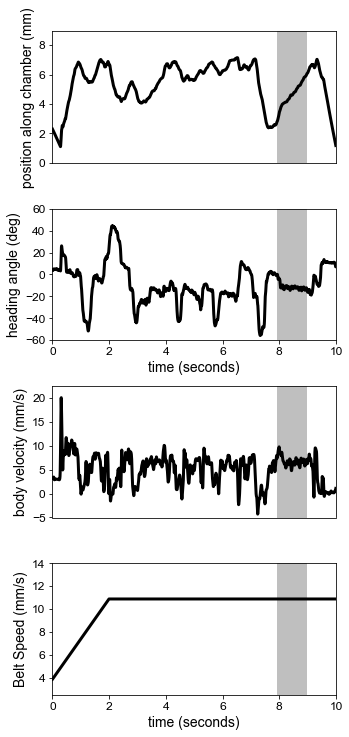

In [43]:
figure_dir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/wt berlin/linear_treadmill/'
t = np.arange(0,trial_samples/FS, 1/FS) # time
body_position = thorax['thorax_x'].values#/BL
vel_BL = lin_vel/BL
shading_color = 'gray'

fig = plt.figure(1, figsize = (5,10))

# body position
plt.subplot(4,1,1)
plt.plot(t, body_position, color ='black', linewidth = 3)
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.ylabel('position along chamber (mm)', fontsize = 14, fontname = 'arial')
plt.xticks([])
# plt.axvspan(454/FS, 508/FS, facecolor=shading_color, alpha=0.5)
plt.axvspan(1428/FS, 1614/FS, facecolor=shading_color, alpha=0.5)
# plt.axhspan(1.25, 2.75, color ='red', alpha = 0.25)
# plt.ylim([0, 8.929/BL])
plt.ylim([0, 8.929])
plt.xlim([0,10])


# body velocity
plt.subplot(4,1,3)
plt.plot(t[1::], vel_BL, color ='black', linewidth = 3)
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.ylabel('body velocity (mm/s)', fontsize = 14, fontname = 'arial')
plt.xticks([])
# plt.axvspan(454/FS, 508/FS, facecolor=shading_color, alpha=0.5)
plt.axvspan(1428/FS, 1614/FS, facecolor=shading_color, alpha=0.5)
# plt.axhline(y = 5/BL, color ='red', linewidth = 2)
plt.xlim([0,10])
plt.ylim([-5, 22.5]) # BL
# plt.ylim([-10, 45]) # mm

# heading angle
plt.subplot(4,1,2)
plt.plot(t, heading_angle, color ='black', linewidth = 3)
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.ylabel('heading angle (deg)', fontsize = 14, fontname = 'arial')
plt.xticks(fontsize = 12, fontname = 'arial')
plt.xlabel('time (seconds)', fontsize = 14, fontname = 'arial')
# plt.axvspan(454/FS, 508/FS, facecolor=shading_color, alpha=0.5)
plt.axvspan(1428/FS, 1614/FS, facecolor=shading_color, alpha=0.5)
# plt.axhspan(-15, 15, color ='red', alpha = 0.25)

plt.xlim([0,10])
plt.ylim([-60, 60])


# heading angle
plt.subplot(4,1,4)
belt_stim = np.zeros(len(heading_angle))
belt_stim[0:2*FS] = np.linspace(adjusted_driving_speeds[0], adjusted_driving_speeds[2], 2*FS)
belt_stim[2*FS::] = adjusted_driving_speeds[2]
plt.plot(t, belt_stim, color ='black', linewidth = 3)
plt.yticks(fontsize = 12, fontname = 'Arial')
plt.ylabel('Belt Speed (mm/s)', fontsize = 14, fontname = 'arial')
plt.xticks(fontsize = 12, fontname = 'arial')
plt.xlabel('time (seconds)', fontsize = 14, fontname = 'arial')
plt.axvspan(1428/FS, 1614/FS, facecolor=shading_color, alpha=0.5)
plt.xlim([0,10])
plt.ylim([2.5, 14])


plt.tight_layout()
plt.show()

# fig.savefig(figure_dir+ 'timeseries body movement_threshold.png', dpi = 300)
# fig.savefig(figure_dir+ 'timeseries body movement_threshold.svg', dpi = 300)

fig.savefig(figure_dir+ 'timeseries body movement_mm_BL.png', dpi = 300)
fig.savefig(figure_dir+ 'timeseries body movement_mm_BL.svg', dpi = 300)

#### Limb trajectories - 3D Trajectories

In [169]:
# start and ending frames of walking bout
sf = 1475
ef = 1610

# isolate leg positions during walking bout
r1x = x_pos[0][sf:ef]/BL
r1y = y_pos[0][sf:ef]/BL
r1z = z_pos_raw[0][sf:ef]/BL

r2x = x_pos[1][sf:ef]/BL
r2y = y_pos[1][sf:ef]/BL
r2z = z_pos_raw[1][sf:ef]/BL

r3x = x_pos[2][sf:ef]/BL
r3y = y_pos[2][sf:ef]/BL
r3z = z_pos_raw[2][sf:ef]/BL

l1x = x_pos[3][sf:ef]/BL
l1y = y_pos[3][sf:ef]/BL
l1z = z_pos_raw[3][sf:ef]/BL

l2x = x_pos[4][sf:ef]/BL
l2y = y_pos[4][sf:ef]/BL
l2z = z_pos_raw[4][sf:ef]/BL

l3x = x_pos[5][sf:ef]/BL
l3y = y_pos[5][sf:ef]/BL
l3z = z_pos_raw[5][sf:ef]/BL

# isolate swing stance matrix during bout
bout_swing_stance = swing_stance_mat_posture[:, sf:ef]

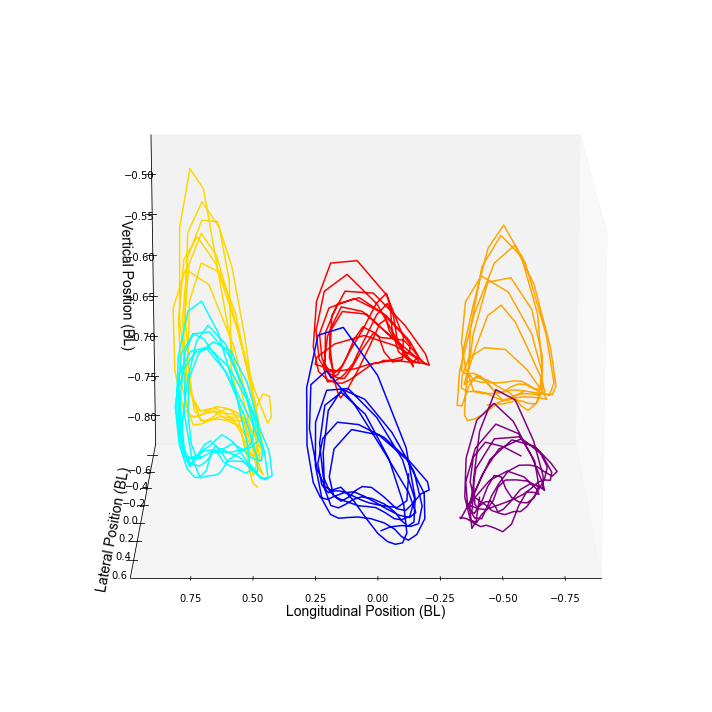

In [178]:
# 3D leg trajectory plot
fig = plt.figure(figsize = [12,10])
ax = plt.axes(projection='3d')

# plot legs
ax.plot3D(r1x, r1y, r1z, 'gold')
ax.plot3D(r2x, r2y, r2z, 'red')
ax.plot3D(r3x, r3y, r3z, 'orange')
ax.plot3D(l1x, l1y, l1z, 'cyan')
ax.plot3D(l2x, l2y, l2z, 'blue')
ax.plot3D(l3x, l3y, l3z, 'purple')

ax.view_init(15, 90) # up down, left right

ax.set_xlabel("Longitudinal Position (BL)", fontsize = 14, fontname = 'Arial')
ax.set_ylabel("Lateral Position (BL)", fontsize = 14, fontname = 'Arial')
ax.set_zlabel("Vertical Position (BL)", fontsize = 14, fontname = 'Arial')
ax.grid(False)

plt.tight_layout()
plt.show()
fig.savefig(savefig_dir + '3d_leg_trajs.png', dpi = 200)
fig.savefig(savefig_dir + '3d_leg_trajs.pdf', dpi = 200)

In [39]:
savefig_dir = 'H:/.shortcut-targets-by-id/10pxdlRXtzFB-abwDGi0jOGOFFNm3pmFK/Tuthill Lab Shared/manuscripts/treadmill_2023/figures/raw/wt berlin/linear_treadmill/'

91
Walking Speed (BL/s) =  6.2838876221947535


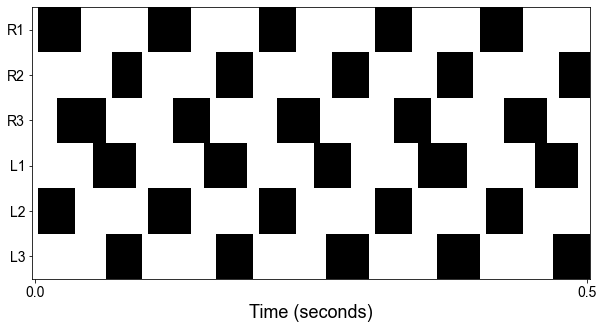

In [50]:
# swing stance plot
sf = 1517
ef = 1608
print(ef-sf)
bout_time = np.arange(0, (ef-sf)/180, 1/180)
bout_swing_stance = swing_stance_mat_posture[:,np.arange(sf, ef)]
print('Walking Speed (BL/s) = ', np.mean(filt_vel_parallel[sf:ef+1]/BL))

fig = plt.figure(1, figsize=[10,5])
plt.xlabel('Time (seconds)', fontsize = 18, fontname = 'Arial')
axes = plt.gca()
axes.set_yticks(np.arange(0, 6, 1))
axes.set_yticklabels(['R1', 'R2', 'R3', 'L1', 'L2', 'L3'], fontsize = 14, fontname = 'Arial')
axes.set_xticks(np.array([0,bout_swing_stance.shape[1]-1]))
axes.set_xticklabels(np.array([bout_time[0], bout_time[-1]]), fontsize = 14, fontname = 'Arial')
plt.imshow(bout_swing_stance, interpolation = 'none', cmap = 'gray',aspect='auto')
plt.show()

fig.savefig(savefig_dir + 'swing_stance_ex_v2.png', dpi = 300)
fig.savefig(savefig_dir + 'swing_stance_ex_v2.svg', dpi = 300)